<a href="https://colab.research.google.com/github/KravitzLab/FED3Analyses/blob/Chonnys-edits/FED3_FR1_V1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FED3 FR1 data analysis
<br>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQqe_1a1j1bQaqhOxq0VvukPqfolLRUqOdl-g&s" width="200" />

Updated: 12-9-25
<br>
Authors: Chantelle Murrell and Sebastian Alves  
Version 1.0.1


In [1]:
# @title Install libraries and import them {"run":"auto"}

import importlib.util
import subprocess
import sys

# Packages to ensure are installed (add others here if you like)
packages = {
    "fed3": "git+https://github.com/earnestt1234/fed3.git",
    "fed3bandit": "fed3bandit",
    "pingouin": "pingouin",
    "ipydatagrid": "ipydatagrid",
    "openpyxl": "openpyxl",
}

for name, source in packages.items():
    if importlib.util.find_spec(name) is None:
        print(f"Installing {name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", source])

# ----------------------------
# Imports
# ----------------------------
# Standard library
import copy
import io
import math
import os
import re
import shutil
import tempfile
import threading
import time
import warnings
import zipfile
import glob
from datetime import datetime, timedelta
from os.path import basename, splitext

# Third-party
from ipydatagrid import DataGrid, TextRenderer
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import fed3
import fed3.plot as fplot
import fed3bandit as f3b
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec
from google.colab import files
from tqdm.auto import tqdm

# ----------------------------
# Configuration
# ----------------------------
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12, 'figure.autolayout': True})
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

print("Packages installed and imports ready.")


Installing fed3...
Installing fed3bandit...
Installing pingouin...
Installing ipydatagrid...
Packages installed and imports ready.


Saving MYT1L_001_FR1_L1.zip to MYT1L_001_FR1_L1.zip
Loaded 40 files. Session types captured for all.


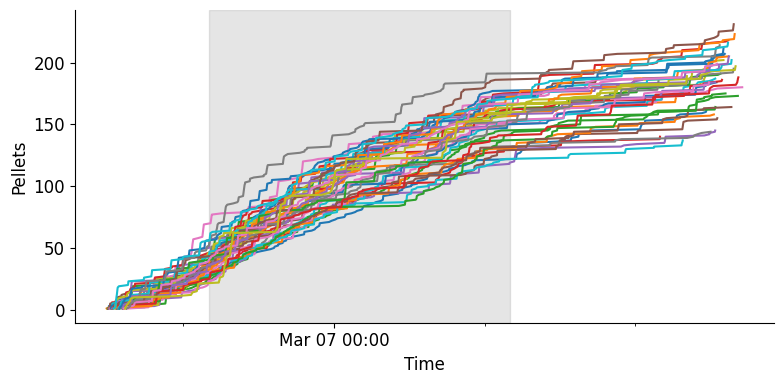

In [2]:
#@title Upload raw FED3 files (individual csvs or a zip folder of multiple csvs)


# Reset caches to avoid duplicates if you re-run this cell
feds, loaded_files, session_types = [], [], []

def extract_session_type(csv_path, fallback="Unknown"):
    """Read 'Session_Type ' or variants; return first non-empty value."""
    try:
        df = pd.read_csv(csv_path, sep=None, engine='python', dtype=str)
        df.columns = [c.strip() for c in df.columns]
        lower = {c.casefold(): c for c in df.columns}
        for cand in ["session_type", "session type", "sessiontype", "session"]:
            if cand in lower:
                col = lower[cand]
                vals = df[col].dropna().astype(str).str.strip()
                vals = vals[vals.ne("")]
                if not vals.empty:
                    return vals.iloc[0]
    except Exception:
        pass
    return fallback

uploaded = files.upload()

for name, data in uploaded.items():
    if name.lower().endswith(".zip"):
        with zipfile.ZipFile(io.BytesIO(data)) as zf:
            for zi in zf.infolist():
                if not zi.filename.lower().endswith(".csv"):
                    continue
                file_data = zf.read(zi)
                if len(file_data) <= 1024:
                    continue
                with tempfile.NamedTemporaryFile(mode="w+b", suffix=".csv", delete=False) as tmp:
                    tmp.write(file_data); tmp_path = tmp.name
                try:
                    session_type = extract_session_type(tmp_path)
                    df = fed3.load(tmp_path)
                    df.name = os.path.basename(zi.filename)
                    df.attrs = {"Session_type": session_type}
                    feds.append(df)
                    loaded_files.append(os.path.basename(zi.filename))
                    session_types.append(session_type)
                except Exception as e:
                    print(f"Error loading {zi.filename}: {e}")
                finally:
                    os.remove(tmp_path)
    elif name.lower().endswith(".csv"):
        if len(data) <= 1024:
            continue
        with tempfile.NamedTemporaryFile(mode="w+b", suffix=".csv", delete=False) as tmp:
            tmp.write(data); tmp_path = tmp.name
        try:
            session_type = extract_session_type(tmp_path)
            df = fed3.load(tmp_path)
            df.name = os.path.basename(name)
            df.attrs = {"Session_type": session_type}
            feds.append(df)
            loaded_files.append(os.path.basename(name))
            session_types.append(session_type)
        except Exception as e:
            print(f"Error loading {name}: {e}")
        finally:
            os.remove(tmp_path)

print(f"Loaded {len(loaded_files)} files. Session types captured for all.")
# Optional quick plot
if feds:
    try:
        fed3.as_aligned(feds, alignment="datetime", inplace=True)
        plt.figure(figsize=(8, 4))
        fplot.line(feds, y='pellets'); plt.legend().remove(); plt.tight_layout(); plt.show()
    except Exception as e:
        print(f"Plotting skipped: {e}")


In [3]:
# @title Build Key


import os, glob, io
import numpy as np
import pandas as pd
from ipydatagrid import DataGrid, TextRenderer
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from google.colab import files as colab_files
from google.colab import output as colab_output

# Require that the file-upload cell has already populated these:
assert 'loaded_files' in globals() and 'session_types' in globals(), \
    "Run the 'Upload FED3 files' cell first."

colab_output.enable_custom_widget_manager()

# ---------------------------
# Base: bare-bones Key_Df from loaded data
# ---------------------------
def _make_base_key_df():
    return pd.DataFrame({"filename": loaded_files, "Session_type": session_types})

def _file_base(s):
    return os.path.splitext(os.path.basename(str(s)))[0].strip()

def _norm_base_lower(s):
    return _file_base(s).lower()

# ---------------------------
# Key scanner: detect Mouse_ID or filename columns
# ---------------------------
def _scan_key_columns(df):
    """
    Returns dict:
      {
        'has_mouse': bool,
        'has_filename': bool,
        'filename_col': 'filename'|'File'|None,
        'msg': str
      }
    Accepts keys that have either Mouse_ID or a filename column (filename/File).
    """
    info = {'has_mouse': False, 'has_filename': False, 'filename_col': None, 'msg': ''}
    try:
        cols = [str(c).strip() for c in df.columns]
        has_mouse = 'Mouse_ID' in cols
        fname_col = 'filename' if 'filename' in cols else ('File' if 'File' in cols else None)
        info.update({
            'has_mouse': has_mouse,
            'has_filename': fname_col is not None,
            'filename_col': fname_col
        })
        if has_mouse:
            info['msg'] = "'Mouse_ID' found."
        elif fname_col:
            info['msg'] = f"'{fname_col}' found; will match on filename."
        else:
            info['msg'] = "Neither 'Mouse_ID' nor 'filename'/'File' found in provided key."
    except Exception as e:
        info['msg'] = f"Error while checking key: {e}"
    return info

# ---------------------------
# Read uploaded key (CSV/XLSX), accept Mouse_ID or filename
# ---------------------------
def _read_key_from_upload(name, content_bytes):
    """Return (df_or_None, message). Reads CSV/XLSX bytes from Colab upload."""
    ext = name.lower().rsplit('.', 1)[-1] if '.' in name else ''
    try:
        bio = io.BytesIO(content_bytes)
        if ext == 'xlsx':
            xls = pd.ExcelFile(bio, engine='openpyxl')
            frames = [pd.read_excel(xls, sheet_name=s) for s in xls.sheet_names]
            key_df = pd.concat(frames, ignore_index=True, sort=False)
        elif ext == 'csv':
            key_df = pd.read_csv(bio, sep=None, engine='python')
        else:
            return None, f"Unsupported key type .{ext}"

        key_df = key_df.copy()
        key_df.columns = [str(c).strip() for c in key_df.columns]
        scan = _scan_key_columns(key_df)
        if not (scan['has_mouse'] or scan['has_filename']):
            return None, scan['msg']

        # Normalize types/columns we might use later
        if scan['has_mouse']:
            key_df['Mouse_ID'] = key_df['Mouse_ID'].astype(str).str.strip()

        if scan['has_filename']:
            fcol = scan['filename_col']
            key_df[fcol] = key_df[fcol].astype(str).str.strip()
            key_df['_key_file_base_lower'] = key_df[fcol].map(_norm_base_lower)

        # Persist a deterministic copy on disk for reproducibility
        fixed_path = f"_uploaded_key.{ext}"
        with open(fixed_path, "wb") as f:
            f.write(content_bytes)
        globals()['uploaded_key_path'] = fixed_path

        return key_df, f"Key loaded from upload ({name}) and saved to {fixed_path}. {scan['msg']}"
    except Exception as e:
        return None, f"Error reading uploaded key: {e}"

# ---------------------------
# Matching filename <-> Mouse_ID
# ---------------------------
def _match_mouse_id_to_filenames(filenames, key_df):
    """Return DataFrame: filename, Mouse_ID, match_status based on Mouse_ID substring in filename."""
    base_names_lower = [_norm_base_lower(f) for f in filenames]
    mouse_ids = (
        key_df['Mouse_ID']
        .dropna().astype(str).map(str.strip)
        .replace({'': np.nan}).dropna().unique().tolist()
    )
    rows = []
    for fname, base in zip(filenames, base_names_lower):
        hits = [mid for mid in mouse_ids if str(mid).lower() in base]
        if len(hits) == 1:
            rows.append({"filename": fname, "Mouse_ID": hits[0], "match_status": "Matched (Mouse_ID in filename)"})
        elif len(hits) > 1:
            longest = max(len(str(h)) for h in hits)
            best = [h for h in hits if len(str(h)) == longest]
            if len(best) == 1:
                rows.append({"filename": fname, "Mouse_ID": best[0], "match_status": "Matched (longest Mouse_ID token)"})
            else:
                rows.append({"filename": fname, "Mouse_ID": None, "match_status": f"Ambiguous Mouse_ID: {hits}"})
        else:
            rows.append({"filename": fname, "Mouse_ID": None, "match_status": "Mouse_ID not found in filename"})
    return pd.DataFrame(rows)

# ---------------------------
# Build/Rematch function
# ---------------------------
status_box = widgets.Output()
Key_Df = _make_base_key_df()  # start bare-bones

def build_or_rematch_key_df(key_df=None, msg_hint=""):
    """
    If key_df provided and valid:
      - Prefer Mouse_ID mapping if key has Mouse_ID.
      - Else fall back to filename merge (case-insensitive basename).
    Else: keep bare-bones.
    """
    global Key_Df
    files_df = _make_base_key_df().copy()
    files_df['_file_base_lower'] = files_df['filename'].map(_norm_base_lower)

    if key_df is None:
        Key_Df = files_df.drop(columns=['_file_base_lower']).copy()
        Key_Df["match_status"] = "No key"
        with status_box:
            clear_output(wait=True)
            print("Key status: No key provided; showing bare-bones Key_Df.")
        return

    # Identify key capabilities
    scan = _scan_key_columns(key_df)
    kd = key_df.copy()

    # Make a unique version of the key for whichever join we use
    def _dedup(df, subset_cols):
        dup_counts = df[subset_cols].astype(str).agg('|'.join, axis=1).value_counts()
        n_dups = int((dup_counts > 1).sum())
        if n_dups:
            with status_box:
                clear_output(wait=True)
                print(f"Note: {n_dups} duplicate key(s) on {subset_cols}; taking the first occurrence.")
        return df.drop_duplicates(subset=subset_cols, keep="first")

    if scan['has_mouse']:
        # Mouse_ID route (preferred)
        kd['Mouse_ID'] = kd['Mouse_ID'].astype(str).str.strip()
        key_unique = _dedup(kd, ['Mouse_ID'])

        matched = _match_mouse_id_to_filenames(files_df['filename'].tolist(), key_unique)[
            ["filename", "Mouse_ID", "match_status"]
        ]

        Key_Df = (
            files_df
            .merge(matched, on="filename", how="left")
            .merge(key_unique, on="Mouse_ID", how="left", suffixes=("", "_key"))
            .drop(columns=['_file_base_lower'])
        )

    elif scan['has_filename']:
        # Filename route (fallback)
        fcol = scan['filename_col']
        kd['_key_file_base_lower'] = kd[fcol].map(_norm_base_lower)
        key_unique = _dedup(kd, ['_key_file_base_lower'])

        Key_Df = (
            files_df
            .merge(key_unique, left_on="_file_base_lower", right_on="_key_file_base_lower", how="left", suffixes=("", "_key"))
            .drop(columns=['_file_base_lower', '_key_file_base_lower'])
        )
        # Give a simple match_status summary for filename matching
        Key_Df["match_status"] = np.where(
            Key_Df[fcol].notna(), "Matched (filename)", "Filename not found in key"
        )
    else:
        # Neither route available (shouldn't happen due to earlier check)
        Key_Df = files_df.drop(columns=['_file_base_lower']).copy()
        Key_Df["match_status"] = "Key missing Mouse_ID and filename columns"

    with status_box:
        clear_output(wait=True)
        if msg_hint:
            print(msg_hint)
        print(f"Merged key columns into Key_Df ({len(Key_Df)} rows, {len(Key_Df.columns)} cols).")

# ---------------------------
# Grid UI
# ---------------------------
def make_grid(df: pd.DataFrame):
    g = DataGrid(
        df,
        editable=True,
        selection_mode='cell',
        layout={'height': '420px'},
        base_row_size=28,
        base_column_size=120,
    )
    g.default_renderer = TextRenderer(text_wrap=True)
    return g

def rebuild_grid(msg=""):
    global grid, ui
    df = Key_Df.copy().reset_index(drop=True)
    new_grid = make_grid(df)
    ui.children = (upload_row, new_grid, controls, status_box)
    grid = new_grid
    with status_box:
        if msg:
            print(msg)
        print(f"Grid now shows Key_Df ({len(df)} rows, {len(df.columns)} cols)")

# ---------------------------
# Colab-native upload button ONLY (no path UI)
# ---------------------------
upload_btn = widgets.Button(description="Upload", button_style="primary", layout=widgets.Layout(width="120px"))
reset_btn = widgets.Button(description="Reset Key", button_style="warning", layout=widgets.Layout(width="120px"))
download_button = widgets.Button(description='Download', button_style='success', layout=widgets.Layout(width="120px"))

def on_colab_upload(_):
    with status_box:
        clear_output(wait=True)
        print("Opening Colab upload dialog...")
    uploaded = colab_files.upload()  # opens the native Colab picker
    if not uploaded:
        with status_box:
            print("No file selected.")
        return
    name, content = next(iter(uploaded.items()))
    key_df, msg = _read_key_from_upload(name, content)
    if key_df is None:
        build_or_rematch_key_df(None)
        rebuild_grid(f"Key status: {msg}")
    else:
        build_or_rematch_key_df(key_df, msg_hint=f"Key status: {msg}")
        rebuild_grid()

def _load_saved_key_from_disk():
    """Returns (key_df_or_None, message) from uploaded_key_path if present/valid."""
    key_path = globals().get('uploaded_key_path', None)
    if not (key_path and os.path.exists(key_path)):
        return None, "No saved key on disk to reload."
    try:
        ext = key_path.lower().rsplit('.', 1)[-1] if '.' in key_path else ''
        if ext == 'xlsx':
            xls = pd.ExcelFile(key_path, engine='openpyxl')
            frames = [pd.read_excel(xls, sheet_name=s) for s in xls.sheet_names]
            key_df = pd.concat(frames, ignore_index=True, sort=False)
        elif ext == 'csv':
            key_df = pd.read_csv(key_path, sep=None, engine='python')
        else:
            return None, f"Unsupported key type .{ext}"

        key_df = key_df.copy()
        key_df.columns = [str(c).strip() for c in key_df.columns]
        scan = _scan_key_columns(key_df)
        if not (scan['has_mouse'] or scan['has_filename']):
            return None, scan['msg']

        if scan['has_mouse']:
            key_df['Mouse_ID'] = key_df['Mouse_ID'].astype(str).str.strip()
        if scan['has_filename']:
            fcol = scan['filename_col']
            key_df[fcol] = key_df[fcol].astype(str).str.strip()
            key_df['_key_file_base_lower'] = key_df[fcol].map(_norm_base_lower)

        return key_df, f"Key reloaded from {os.path.basename(key_path)}. {scan['msg']}"
    except Exception as e:
        return None, f"Error reading saved uploaded key: {e}"

def on_reset(_):
    """
    HARD RESET: forget any saved key and show bare-bones Key_Df.
    Deletes _uploaded_key.(xlsx|csv) if present and clears uploaded_key_path.
    """
    # 1) Forget path in memory
    globals().pop('uploaded_key_path', None)

    # 2) Remove any persisted key files from disk
    import os
    for ext in ("xlsx", "csv"):
        try:
            os.remove(f"_uploaded_key.{ext}")
        except FileNotFoundError:
            pass

    # 3) Show bare-bones
    build_or_rematch_key_df(None)
    rebuild_grid("Reset: cleared saved key; showing bare-bones Key_Df.")

def download_df(_):
    global Key_Df
    with status_box:
        clear_output(wait=True)
        print("Saving latest Key_Df as XLSX ...")
    try:
        path = "/content/Key_Df.xlsx"
        Key_Df.to_excel(path, index=False, engine='openpyxl')
        colab_files.download(path)
        with status_box:
            clear_output(wait=True)
            print("Saved and downloading Key_Df.xlsx ...")
    except Exception as e:
        with status_box:
            clear_output(wait=True)
            print(f"Error while saving/downloading: {e}")

upload_btn.on_click(on_colab_upload)
reset_btn.on_click(on_reset)
download_button.on_click(download_df)

upload_row = widgets.HBox([
    widgets.HTML("<b>Optional key:</b>"),
    upload_btn,
    reset_btn,
    download_button
])

# ---------------------------
# Edit / rematch / download controls
# ---------------------------
new_col_name    = widgets.Text(placeholder='Enter new column name', description='New Col:')
add_col_button  = widgets.Button(description='Add Column', button_style='info')
apply_button    = widgets.Button(description='Apply Changes', button_style='primary', layout=widgets.Layout(width="120px"))

def add_column(_):
    global Key_Df
    col = new_col_name.value.strip()
    with status_box:
        clear_output(wait=True)
        if not col:
            print("Please enter a column name."); return
        if col in Key_Df.columns:
            print(f"Column '{col}' already exists."); return
        Key_Df[col] = ""
        print(f"Added column '{col}' to Key_Df.")
    rebuild_grid()

def apply_edits(_):
    global Key_Df
    try:
        Key_Df = grid.data.copy().reset_index(drop=True)
        with status_box:
            clear_output(wait=True)
            print(f"Applied grid edits to Key_Df ({len(Key_Df)} rows, {len(Key_Df.columns)} cols).")
    except Exception as e:
        with status_box:
            clear_output(wait=True)
            print(f"Error applying edits: {e}")

add_col_button.on_click(add_column)
apply_button.on_click(apply_edits)

controls = widgets.HBox([new_col_name, add_col_button, apply_button])

# ---------------------------
# Initialize UI
# ---------------------------
Key_Df = _make_base_key_df()
Key_Df["match_status"] = "No key"

grid = make_grid(Key_Df.copy().reset_index(drop=True))
ui = widgets.VBox([upload_row, grid, controls, status_box])
display(ui)

Saving MYT1L_001_Key.xlsx to MYT1L_001_Key.xlsx


In [4]:
# @title Analyze FR1 metrics

import os
import re
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from datetime import datetime

# Use the cropped list if present, else the full list
files_list = feds
assert isinstance(files_list, list) and len(files_list) > 0, "No FED3 files loaded."
assert 'Key_Df' in globals() and isinstance(Key_Df, pd.DataFrame), "Build/rematch Key_Df first."

# metadata_df = copy of Key_Df
metadata_df = Key_Df.copy().reset_index(drop=True)
if 'filename' in metadata_df.columns:
    metadata_df['filename'] = metadata_df['filename'].astype(str).map(os.path.basename)

# ---------------------------
# Requirements
# ---------------------------
assert 'metadata_df' in globals() and isinstance(metadata_df, pd.DataFrame), \
    "metadata_df not found. Build/rematch Key_Df and set metadata_df = Key_Df.copy() first."

def _basename(pathlike) -> str:
    s = str(pathlike).replace("\\", "/")
    return s.split("/")[-1]

def _get_sessions():
    if 'feds' in globals() and isinstance(feds, (list, tuple)) and len(feds) > 0:
        return list(feds)
    raise RuntimeError("No FED3 sessions found. Expecting a non-empty 'feds' list.")

def _safe_col(df, candidates):
    # case/spacing/hyphen tolerant lookup
    norm = lambda s: str(s).strip().lower().replace('-', '_').replace(' ', '_')
    lmap = {norm(c): c for c in df.columns}
    for cand in candidates:
        key = norm(cand)
        if key in lmap:
            return lmap[key]
    return None

def _prep_events(df):
    """Return filtered df with only Left/Right/Pellet and the resolved Event column name."""
    ev_col = _safe_col(df, ["Event", "event"])
    if ev_col is None:
        return df.iloc[0:0].copy(), None
    return df[df[ev_col].isin(["Left", "Right", "Pellet"])].copy(), ev_col

def _pellet_times_from_df(df):
    ev_col = _safe_col(df, ["Event", "event"])
    if ev_col is None:
        return []
    pel = df[df[ev_col] == "Pellet"]
    # prefer datetime-like index; else common timestamp columns; else index
    if isinstance(pel.index, pd.DatetimeIndex):
        ts = pel.index.to_series()
    else:
        for cand in ["MM:DD:YYYY hh:mm:ss", "DateTime", "Datetime", "Timestamp", "timestamp", "datetime"]:
            if cand in pel.columns:
                ts = pd.to_datetime(pel[cand], errors="coerce")
                break
        else:
            ts = pd.to_datetime(pel.index, errors="coerce")
    ts = ts.dropna().sort_values()
    return ts.to_list()

def _get_ts_series_from_col_or_index(df, ts_candidates=("MM:DD:YYYY hh:mm:ss","DateTime","Datetime","Timestamp","timestamp","datetime")):
    """Return a pandas Series of datetimes aligned to df.index."""
    for cand in ts_candidates:
        if cand in df.columns:
            ts = pd.to_datetime(df[cand], errors="coerce")
            # align to index shape
            if not isinstance(ts, pd.Series):
                ts = pd.Series(ts, index=df.index)
            else:
                ts = ts.reindex(df.index)
            return ts
    if isinstance(df.index, pd.DatetimeIndex):
        return pd.Series(df.index, index=df.index)
    return pd.to_datetime(pd.Series(df.index, index=df.index), errors="coerce")

def _split_day_night_masks(ts):
    """Day: 06:00<=h<18:00; Night: otherwise."""
    valid = ts.notna()
    hrs = ts.dt.hour
    day_mask = valid & (hrs >= 6) & (hrs < 18)
    night_mask = valid & ~day_mask
    return day_mask, night_mask

def _cluster_times(ts_list, max_interval_sec=60):
    if not ts_list:
        return []
    clusters, current = [], [ts_list[0]]
    for i in range(1, len(ts_list)):
        if (ts_list[i] - ts_list[i-1]).total_seconds() <= max_interval_sec:
            current.append(ts_list[i])
        else:
            clusters.append(current); current = [ts_list[i]]
    clusters.append(current)
    return clusters

def _subset_meal_metrics(df, ts_series, max_interval_sec=60):
    """
    Compute pellet/meal metrics for a subset given df and ts_series (Series).
    Returns dict with keys:
      '%MealPellets','%GrazingPellets','Pellets',
      'NumMeals','AvgMealSize','AvgMealDuration','MealsPerHour','Accuracy'
    """
    out = {
        "%MealPellets": np.nan,
        "%GrazingPellets": np.nan,
        "Pellets": 0,
        "NumMeals": np.nan,
        "AvgMealSize": np.nan,
        "AvgMealDuration": np.nan,
        "MealsPerHour": np.nan,
        "Accuracy": np.nan,
    }
    ev_col = _safe_col(df, ["Event", "event"])
    if ev_col is None or df.empty:
        return out

    left_n = int((df[ev_col] == "Left").sum())
    right_n = int((df[ev_col] == "Right").sum())
    denom = left_n + right_n
    if denom > 0:
        out["Accuracy"] = 100.0 * (left_n / denom)

    pel_mask = (df[ev_col] == "Pellet")
    pel_ts = ts_series[pel_mask].dropna().sort_values()
    out["Pellets"] = int(pel_ts.size)
    if pel_ts.size == 0:
        return out

    ts_list = pel_ts.to_list()
    clusters = _cluster_times(ts_list, max_interval_sec=max_interval_sec)
    meal_clusters = [c for c in clusters if len(c) >= 3]
    grazing_clusters = [c for c in clusters if 1 <= len(c) < 3]

    meal_pellets = sum(len(c) for c in meal_clusters)
    grazing_pellets = sum(len(c) for c in grazing_clusters)
    total_pg = meal_pellets + grazing_pellets
    if total_pg > 0:
        out["%MealPellets"] = 100.0 * meal_pellets / total_pg
        out["%GrazingPellets"] = 100.0 * grazing_pellets / total_pg

    if len(meal_clusters) > 0:
        out["NumMeals"] = float(len(meal_clusters))
        out["AvgMealSize"] = float(np.mean([len(c) for c in meal_clusters]))
        out["AvgMealDuration"] = float(np.mean([(c[-1] - c[0]).total_seconds() for c in meal_clusters]))
    else:
        out["NumMeals"] = 0.0

    if len(ts_list) >= 2:
        rec_hours = (ts_list[-1] - ts_list[0]).total_seconds() / 3600.0
        if rec_hours > 0:
            out["MealsPerHour"] = (out["NumMeals"] / rec_hours) if np.isfinite(out["NumMeals"]) else np.nan
    return out

def _estimate_daily_pellets(df):
    """
    24h-normalized pellet rate; prefer Pellet_Count if present (numeric non-NaN),
    fallback to counting 'Pellet' events. Uses total span between first and last timestamp.
    """
    # Need at least two timestamps
    ts = _get_ts_series_from_col_or_index(df)
    ts = ts.dropna().sort_values()
    if ts.size < 2:
        return np.nan
    duration_hours = (ts.iloc[-1] - ts.iloc[0]).total_seconds() / 3600.0
    if duration_hours <= 0:
        return np.nan

    pellet_events = np.nan
    pc_col = _safe_col(df, ["Pellet_Count", "pellet_count"])
    if pc_col is not None:
        pc = pd.to_numeric(df[pc_col], errors='coerce')
        if pc.notna().any():
            diffs = pc.diff().fillna(0).clip(lower=0)
            pellet_events = float(diffs.sum())
            if pellet_events == 0 and pc.iloc[-1] >= pc.iloc[0]:
                pellet_events = float(pc.iloc[-1] - pc.iloc[0])

    if np.isnan(pellet_events):
        ev_col = _safe_col(df, ["Event", "event"])
        if ev_col is not None:
            pellet_events = float((df[ev_col] == "Pellet").sum())

    if np.isnan(pellet_events):
        return np.nan
    return (pellet_events / duration_hours) * 24.0

# ---------------------------
# Load sessions and normalize metadata_df
# ---------------------------
_sessions = _get_sessions()

md = metadata_df.copy()
if 'filename' not in md.columns:
    raise ValueError("metadata_df must contain a 'filename' column.")
if 'Mouse_ID' not in md.columns:
    raise ValueError("metadata_df must contain a 'Mouse_ID' column.")
md['filename'] = md['filename'].astype(str).map(_basename)
md['Mouse_ID'] = md['Mouse_ID'].astype(str).str.strip()

# ---------------------------
# Core FR1 metrics per file (includes Daily_Pellets & LeftWithPellet)
# ---------------------------
rows = []
for idx, c_df in enumerate(_sessions):
    file_name = _basename(getattr(c_df, "name", f"File_{idx}"))
    d, ev = _prep_events(c_df)

    if ev is None or d.empty:
        pellets = left = right = lwp = 0
        rt_med = ipi_med = pt_med = np.nan
    else:
        pellets = int((d[ev] == "Pellet").sum())
        left    = int((d[ev] == "Left").sum())
        right   = int((d[ev] == "Right").sum())
        # LeftWithPellet counted on the raw df to be safe
        lwp     = int((c_df[ev] == "LeftWithPellet").sum()) if ev in c_df.columns else 0

        rt_col  = _safe_col(d, ["Retrieval_Time", "retrieval_time"])
        ipi_col = _safe_col(d, ["InterPelletInterval", "interpelletinterval", "inter_pellet_interval"])
        pt_col  = _safe_col(d, ["Poke_Time", "poke_time"])

        rt_med  = pd.to_numeric(d.get(rt_col, pd.Series(dtype=float)), errors="coerce").median() if rt_col else np.nan
        ipi_med = pd.to_numeric(d.get(ipi_col, pd.Series(dtype=float)), errors="coerce").median() if ipi_col else np.nan
        pt_med  = pd.to_numeric(d.get(pt_col, pd.Series(dtype=float)), errors="coerce").median() if pt_col else np.nan

    total_pokes = left + right
    acc = (left / total_pokes * 100.0) if total_pokes > 0 else np.nan
    ppp = (total_pokes / pellets) if pellets > 0 else np.nan

    daily_pel = _estimate_daily_pellets(c_df)

    rows.append({
        "File": file_name,
        "FileIndex": idx,
        "Pellets": pellets,
        "Left_Poke": left,
        "Right_Poke": right,
        "Total_Pokes": total_pokes,
        "Accuracy": acc,
        "PokesPerPellet": ppp,
        "RetrievalTime": rt_med,
        "InterPelletInterval": ipi_med,
        "PokeTime": pt_med,
        "Daily_Pellets": daily_pel,
        "Left Poke with Pellet": lwp,
    })

FR1metrics = pd.DataFrame(rows)
if FR1metrics.empty:
    display(HTML("<b style='color:#b00'>No files to analyze.</b>"))
    raise SystemExit

def compute_within_meal_mode_from_sessions(sessions, max_interval_sec=60, min_samples=5):
    """
    For each session/file:
      - take InterPelletInterval > 0 and <= max_interval_sec
      - find the mode of the distribution in log10 space
      - return peak converted back to seconds
    Falls back to a log-hist peak if scipy is unavailable.
    """
    rows = []
    try:
        from scipy.stats import gaussian_kde
        use_kde = True
    except Exception:
        use_kde = False

    for i, df in enumerate(sessions):
        file = _basename(getattr(df, "name", f"File_{i}"))
        ipi_col = _safe_col(df, ["InterPelletInterval", "interpelletinterval", "inter_pellet_interval"])
        if ipi_col is None or df.empty:
            rows.append({"File": file, "Within_meal_pellet_rate": np.nan}); continue

        vals = pd.to_numeric(df[ipi_col], errors="coerce").dropna()
        vals = vals[(vals > 0) & (vals <= max_interval_sec)]
        if vals.size < min_samples:
            rows.append({"File": file, "Within_meal_pellet_rate": np.nan}); continue

        logv = np.log10(vals.values)

        if use_kde:
            kde = gaussian_kde(logv, bw_method="scott")
            xs  = np.linspace(logv.min(), logv.max(), 1000)
            ys  = kde(xs)
            peak_log10 = xs[np.argmax(ys)]
        else:
            # robust fallback: log-histogram mode
            xs = np.linspace(logv.min(), logv.max(), 256)
            hist, edges = np.histogram(logv, bins=xs)
            centers = 0.5 * (edges[:-1] + edges[1:])
            peak_log10 = centers[np.argmax(hist)]

        peak_seconds = float(10.0 ** peak_log10)
        rows.append({"File": file, "Within_meal_pellet_rate": peak_seconds})

    return pd.DataFrame(rows)
# ---------------------------
# Meal/grazing metrics (file-level)
# ---------------------------
def compute_meal_bout_metrics_from_sessions(sessions, max_interval_sec=60):
    rows, recinfo = [], []
    for i, df in enumerate(sessions):
        file = _basename(getattr(df, "name", f"File_{i}"))
        ts = _pellet_times_from_df(df)
        if len(ts) < 2:
            continue
        duration_hr = (ts[-1] - ts[0]).total_seconds() / 3600.0
        recinfo.append({"File": file, "RecordingHours": duration_hr})

        clusters = _cluster_times(ts, max_interval_sec=max_interval_sec)
        meal_id = 0
        for c in clusters:
            if len(c) >= 3:
                rows.append({
                    "File": file,
                    "MealID": meal_id,
                    "MealSize": len(c),
                    "MealDuration_sec": (c[-1] - c[0]).total_seconds(),
                })
                meal_id += 1
    meal_df = pd.DataFrame(rows)
    rec_df  = pd.DataFrame(recinfo)
    if meal_df.empty:
        out = pd.DataFrame(columns=["File","NumMeals","AvgMealSize","AvgMealDuration","RecordingHours","MealsPerHour"])
    else:
        out = (meal_df.groupby("File")
               .agg(NumMeals=("MealID","count"), AvgMealSize=("MealSize","mean"), AvgMealDuration=("MealDuration_sec","mean"))
               .reset_index())
    out = out.merge(rec_df, on="File", how="left")
    out["MealsPerHour"] = out["NumMeals"] / out["RecordingHours"]
    return out

def compute_meal_pellet_distribution_from_sessions(sessions, max_interval_sec=60):
    rows = []
    for i, df in enumerate(sessions):
        file = _basename(getattr(df, "name", f"File_{i}"))
        ts = _pellet_times_from_df(df)
        if len(ts) == 0:
            rows.append({"File": file, "%MealPellets": np.nan, "%GrazingPellets": np.nan})
            continue
        clusters = _cluster_times(ts, max_interval_sec=max_interval_sec)
        meal_pellets    = sum(len(c) for c in clusters if len(c) >= 3)
        grazing_pellets = sum(len(c) for c in clusters if 1 <= len(c) < 3)
        total = meal_pellets + grazing_pellets
        rows.append({
            "File": file,
            "%MealPellets": (100 * meal_pellets / total) if total else np.nan,
            "%GrazingPellets": (100 * grazing_pellets / total) if total else np.nan
        })
    return pd.DataFrame(rows)

meal_info_df   = compute_meal_bout_metrics_from_sessions(_sessions, max_interval_sec=60)
pellet_dist_df = compute_meal_pellet_distribution_from_sessions(_sessions, max_interval_sec=60)

FR1_enriched = (
    FR1metrics
    .merge(pellet_dist_df, on="File", how="left")
    .merge(meal_info_df, on="File", how="left")
)
wmpr_df = compute_within_meal_mode_from_sessions(_sessions, max_interval_sec=60, min_samples=5)
FR1_enriched = FR1_enriched.merge(wmpr_df, on="File", how="left")
# ---------------------------
# Day/Night metrics per file
# ---------------------------
_day_night_bases = ["%MealPellets","%GrazingPellets","Pellets","NumMeals","AvgMealSize","AvgMealDuration","MealsPerHour","Accuracy"]
for base in _day_night_bases:
    FR1_enriched[f"{base}_Day"] = np.nan
    FR1_enriched[f"{base}_Night"] = np.nan

for i, df_all in enumerate(_sessions):
    file = _basename(getattr(df_all, "name", f"File_{i}"))
    ts_all = _get_ts_series_from_col_or_index(df_all)
    day_mask, night_mask = _split_day_night_masks(ts_all)

    day_df = df_all.loc[day_mask]
    night_df = df_all.loc[night_mask]

    day_vals = _subset_meal_metrics(day_df, ts_all.loc[day_mask])
    night_vals = _subset_meal_metrics(night_df, ts_all.loc[night_mask])

    row_mask = FR1_enriched["File"] == file
    for base in _day_night_bases:
        FR1_enriched.loc[row_mask, f"{base}_Day"] = day_vals[base]
        FR1_enriched.loc[row_mask, f"{base}_Night"] = night_vals[base]

# ---------------------------
# Attach metadata: Mouse_ID primary, filename fallback
# ---------------------------
# 1) Map filename -> Mouse_ID from metadata_df
mouse_map = md.set_index('filename')['Mouse_ID']
FR1_enriched['Mouse_ID'] = FR1_enriched['File'].map(mouse_map)

# 2) Primary merge by Mouse_ID
md_mouse_unique = md.drop_duplicates(subset=['Mouse_ID'], keep='first')
fm = FR1_enriched.merge(md_mouse_unique, on='Mouse_ID', how='left', suffixes=('', '_md'))


# 3) Fallback for rows still missing metadata -> merge by filename
needs_fallback = fm['Mouse_ID'].isna() | fm.filter(regex='_md$').isna().all(axis=1)
if needs_fallback.any():
    md_file_unique = md.drop_duplicates(subset=['filename'], keep='first')
    fm_fb = FR1_enriched.loc[needs_fallback].merge(
        md_file_unique, left_on='File', right_on='filename', how='left', suffixes=('', '_md')
    )
    fm = pd.concat([fm.loc[~needs_fallback], fm_fb], ignore_index=True)

# ---------------------------
# Session-type suffixing (apply to ALL metrics)
# ---------------------------
# Include day/night columns plus the new metrics
metric_cols_all = [
    "Pellets", "Left_Poke", "Right_Poke", "Total_Pokes", "Accuracy",
    "PokesPerPellet", "RetrievalTime", "InterPelletInterval", "PokeTime",
    "%MealPellets", "%GrazingPellets", "NumMeals", "AvgMealSize",
    "AvgMealDuration", "RecordingHours", "MealsPerHour",
    "Daily_Pellets", "Left Poke with Pellet","Within_meal_pellet_rate",
    # Day/Night exact column names:
    "%MealPellets_Day","%GrazingPellets_Day","Pellets_Day","NumMeals_Day","AvgMealSize_Day","AvgMealDuration_Day","MealsPerHour_Day","Accuracy_Day",
    "%MealPellets_Night","%GrazingPellets_Night","Pellets_Night","NumMeals_Night","AvgMealSize_Night","AvgMealDuration_Night","MealsPerHour_Night","Accuracy_Night",
]

# Prefer metadata_df's Session_type; fallback to df.attrs or "Unknown"
if 'Session_type' in fm.columns:
    session_series = fm['Session_type'].astype(str).str.strip()
else:
    sess_map = {
        _basename(getattr(_sessions[i], "name", f"File_{i}")):
        (_sessions[i].attrs.get("Session_type") or "Unknown")
        for i in range(len(_sessions))
    }
    session_series = fm["File"].map(sess_map).fillna("Unknown").astype(str)

session_series = session_series.str.replace(r"\s+", "_", regex=True)
fm["_Session_type_for_csv"] = session_series

def with_session_suffix_for_csv(df, metrics=metric_cols_all, session_col="_Session_type_for_csv"):
    df = df.copy()
    for m in metrics:
        if m not in df.columns:
            continue
        for sess in df[session_col].dropna().unique():
            mask = df[session_col] == sess
            col_name = f"{m}_{sess}"
            if col_name not in df.columns:
                df[col_name] = np.nan
            df.loc[mask, col_name] = df.loc[mask, m]
        df.drop(columns=[m], inplace=True)
    return df.drop(columns=[session_col])

FR1metrics_merged = fm.copy()      # optional to inspect in notebook
FR1metrics_csv    = with_session_suffix_for_csv(FR1metrics_merged)

# ---------------------------
# KEEP ONLY requested columns for CSV
# ---------------------------
def _norm_name(s: str) -> str:
    # lowercase, strip non-alphanumerics (so "Sex$", "Session type" normalize nicely)
    return re.sub(r'[^a-z0-9]+', '', str(s).lower())

# Meta targets we want to keep (prefix match allows *_md, etc.)
meta_targets = ["mouse_id", "filename", "session_type", "sex", "genotype"]
#meta_targets = ["mouseid", "filename", "sessiontype", "sex", "genotype",
#                "geneid", "fed3", "beam"]

# For each target, pick the best matching column:
#   1) exact normalized == target (preferred)
#   2) otherwise any column whose normalized name startswith(target)
allowed_meta = []
all_cols_norm = {c: _norm_name(c) for c in FR1metrics_csv.columns}
for tgt in meta_targets:
    exact = [c for c, k in all_cols_norm.items() if k == tgt]
    if exact:
        allowed_meta.append(exact[0])
        continue
    prefixed = [c for c, k in all_cols_norm.items() if k.startswith(tgt)]
    if prefixed:
        # Prefer the shortest normalized name (likely the least-suffixed)
        prefixed.sort(key=lambda c: len(all_cols_norm[c]))
        allowed_meta.append(prefixed[0])

# Metric columns: base or any session-suffixed variant (e.g., Pellets_FR1)
def _metric_match(col):
    return any(col == base or col.startswith(base + "_") for base in metric_cols_all)

metric_keep = [c for c in FR1metrics_csv.columns if _metric_match(c)]

# Final selection (keep only the meta we found + metrics)
keep_cols = [c for c in allowed_meta if c is not None] + metric_keep
if not metric_keep:
    raise RuntimeError("No metric columns matched; check 'metric_cols_all' and your column names.")

FR1metrics_csv = FR1metrics_csv.loc[:, keep_cols]

# ---------------------------
# Save & present
# ---------------------------
# Try to build filename from key: Gene_GeneID_FR1_L3.csv
gene_col   = _safe_col(md, ["Gene", "gene"])
geneid_col = _safe_col(md, ["Gene_ID", "GeneID", "gene_id", "geneid"])
if gene_col is not None and geneid_col is not None:
    # Extract unique values
    gene_vals   = md[gene_col].dropna().astype(str).str.strip().unique()
    geneid_vals = md[geneid_col].dropna().astype(str).str.strip().unique()
    gene = gene_vals[0] if gene_vals.size > 0 else "GENE"
    # Zero-pad Gene_ID → 3 digits
    if geneid_vals.size > 0:
        raw_gene_id = geneid_vals[0]
        # remove accidental non-digits but keep fallback behavior
        cleaned = re.sub(r"[^0-9]", "", raw_gene_id)
        if cleaned.isdigit():
            gene_id = cleaned.zfill(3)   # <<< zero-padding here
        else:
            gene_id = raw_gene_id        # fallback if not numeric
    else:
        gene_id = "000"
    # Build name: Gene_GeneID_FR1_L3
    base_name = f"{gene}_{gene_id}_FR1_L3"
    base_name = re.sub(r"[^A-Za-z0-9_\-]+", "_", base_name)  # sanitize
    fname = f"{base_name}.csv"
else:
    # Fallback to timestamp
    fname = f"FR1metrics_{datetime.now():%Y%m%d_%H%M%S}.csv"
FR1metrics_csv.to_csv(fname, index=False)
display(HTML(f"<b>✓ Saved FR1 metrics CSV (trimmed columns) to:</b> <code>{fname}</code>"))
try:
    from google.colab import files as gfiles
    btn = widgets.Button(description=f"Download {os.path.basename(fname)}", icon="download",
                         tooltip="Click to download the FR1 metrics CSV")
    status = widgets.HTML()
    def _on_click(_):
        clear_output(wait=True); display(btn, status)
        try:
            status.value = f"Starting download: <code>{os.path.basename(fname)}</code>…"
            gfiles.download(fname)
        except Exception as e:
            status.value = f"<b style='color:#b00'>Download failed:</b> {e}"
    display(btn, status)
    btn.on_click(_on_click)
except Exception:
    pass

Button(description='Download MYT1L_001_FR1_L3.csv', icon='download', style=ButtonStyle(), tooltip='Click to do…

HTML(value='')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title Group for plotting

import os
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- sanity ---
if 'metadata_df' not in globals() or metadata_df is None or metadata_df.empty:
    raise RuntimeError("metadata_df is missing or empty. Build metadata_df (copy of Key_Df) first.")

EXCLUDE_LOWER = {"match_status"}   # everything else is allowed

def _build_file_column(df):
    if "filename" in df.columns:
        return df["filename"].apply(lambda p: os.path.basename(str(p)))
    if "FED3_from_file" in df.columns and "Date_from_file" in df.columns:
        return "FED" + df["FED3_from_file"].astype(str) + "_" + df["Date_from_file"].astype(str)
    if "FED3_from_file" in df.columns:
        return "FED" + df["FED3_from_file"].astype(str)
    return df.index.astype(str)

def _norm_val(x):
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return "UNK"
    return s.upper()

def _build_group_row(row, ordered_cols):
    if not ordered_cols:
        return "ALL"
    return " | ".join(_norm_val(row[c]) for c in ordered_cols)

def build_mapping(ordered_cols):
    _meta = metadata_df.copy()
    _meta["File"] = _build_file_column(_meta)
    _meta["Group"] = _meta.apply(lambda r: _build_group_row(r, ordered_cols), axis=1)
    mapping = (
        _meta[["File", "Group"]]
        .dropna(subset=["File"])
        .drop_duplicates()
        .sort_values(["Group", "File"])
        .reset_index(drop=True)
    )
    return mapping

def _unique_keep_order(seq):
    seen = set(); out = []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out

# ---------- UI (fixed sizes + grid) ----------
PX_W = "260px"   # list box width
PX_H = "160px"   # list box height
BTN_W = "160px"  # button column width
HDR_H = "28px"   # header cell height (consistent across all headers)

title = widgets.HTML("<h3>Select columns to group by for X and Hue, then reorder X to set hierarchy</h3>")

all_cols = sorted((c for c in metadata_df.columns if str(c).lower() not in EXCLUDE_LOWER), key=str.lower)

def header(text):
    # Normalize header height/margins so they align perfectly in the grid row
    return widgets.HTML(
        f"<div style='height:{HDR_H};display:flex;align-items:flex-end;'>"
        f"<h4 style=\"margin:0;\">{text}</h4></div>"
    )

# Headers (row 1 of grid)
available_hdr = header("Available")
actions_hdr   = header("Actions")
x_hdr         = header("X grouping")
hue_hdr       = header("Hue grouping")

# Widgets (row 2 of grid)
available = widgets.SelectMultiple(
    options=all_cols, value=tuple(), rows=14,
    layout=widgets.Layout(
        width=PX_W, height=PX_H, min_width=PX_W, max_width=PX_W,
        min_height=PX_H, max_height=PX_H, flex="0 0 auto"
    )
)

right_x = widgets.Select(
    options=[], value=None, rows=8,
    layout=widgets.Layout(
        width=PX_W, height=PX_H, min_width=PX_W, max_width=PX_W,
        min_height=PX_H, max_height=PX_H, flex="0 0 auto"
    )
)

right_hue = widgets.Select(
    options=[], value=None, rows=8,
    layout=widgets.Layout(
        width=PX_W, height=PX_H, min_width=PX_W, max_width=PX_W,
        min_height=PX_H, max_height=PX_H, flex="0 0 auto"
    )
)

# Buttons
btn_add_x    = widgets.Button(description="Add to X ▶", button_style='primary', layout=widgets.Layout(width=BTN_W))
btn_add_hue  = widgets.Button(description="Add to Hue ▶",button_style='primary', layout=widgets.Layout(width=BTN_W))
btn_clear    = widgets.Button(description="Clear", button_style='danger', layout=widgets.Layout(width=BTN_W))
btn_up       = widgets.Button(description="↑ Up (X only)", layout=widgets.Layout(width=BTN_W))
btn_down     = widgets.Button(description="↓ Down (X only)", layout=widgets.Layout(width=BTN_W))
btn_build    = widgets.Button(description="Build Groups", button_style='success', layout=widgets.Layout(width="160px"))

controls_col = widgets.VBox(
    [btn_add_x, btn_add_hue, btn_clear, btn_up, btn_down],
    layout=widgets.Layout(
        align_items="center",
        width=BTN_W, min_width=BTN_W, max_width=BTN_W,
        height=PX_H, min_height=PX_H, max_height=PX_H,
        flex="0 0 auto"
    )
)

btn_build = widgets.Button(description="Build Groups", button_style='success', layout=widgets.Layout(width="160px"))
output = widgets.Output()

# --- Callbacks ---
def on_add_x(_):
    sel = list(available.value)
    if not sel: return
    new_opts = _unique_keep_order(list(right_x.options) + sel)
    right_x.value = None
    right_x.options = new_opts
    right_x.value = new_opts[-1] if new_opts else None

def on_add_hue(_):
    sel = list(available.value)
    if not sel: return
    new_opts = _unique_keep_order(list(right_hue.options) + sel)
    right_hue.value = None
    right_hue.options = new_opts
    right_hue.value = new_opts[-1] if new_opts else None

def on_clear(_):
    right_x.value = None; right_x.options = []
    right_hue.value = None; right_hue.options = []

def on_up(_):
    item = right_x.value
    if item is None: return
    opts = list(right_x.options)
    i = opts.index(item)
    if i > 0:
        opts[i-1], opts[i] = opts[i], opts[i-1]
        right_x.value = None; right_x.options = opts; right_x.value = item

def on_down(_):
    item = right_x.value
    if item is None: return
    opts = list(right_x.options)
    i = opts.index(item)
    if i < len(opts) - 1:
        opts[i+1], opts[i] = opts[i], opts[i+1]
        right_x.value = None; right_x.options = opts; right_x.value = item

def on_build(_):
    with output:
        clear_output()
        ordered_cols_x = list(right_x.options)
        ordered_cols_hue = list(right_hue.options)

        mapping_x = build_mapping(ordered_cols_x)
        mapping_hue = build_mapping(ordered_cols_hue)

        _meta = metadata_df.copy()
        _meta["File"] = _build_file_column(_meta)
        _meta["XGroup"] = _meta.apply(lambda r: _build_group_row(r, ordered_cols_x), axis=1)
        _meta["HueGroup"] = _meta.apply(lambda r: _build_group_row(r, ordered_cols_hue), axis=1)
        mapping_both = (
            _meta[["File", "XGroup", "HueGroup"]]
            .dropna(subset=["File"])
            .drop_duplicates()
            .sort_values(["XGroup", "HueGroup", "File"])
            .reset_index(drop=True)
        )

        globals()['files_to_group_x'] = mapping_x.copy()
        globals()['files_to_group_hue'] = mapping_hue.copy()
        globals()['files_to_group_both'] = mapping_both.copy()
        globals()['selected_group_cols_x'] = ordered_cols_x.copy()
        globals()['selected_group_cols_hue'] = ordered_cols_hue.copy()

        print("X-axis grouping (hierarchy):", ordered_cols_x if ordered_cols_x else ["ALL"])
        print(f"Total unique files (X map): {mapping_x['File'].nunique()}")
        display(widgets.HTML("<b>X-group summary</b>"))
        display((mapping_x.groupby("Group", dropna=False)["File"]
                 .nunique().sort_values(ascending=False)
                 .rename("UniqueFiles").to_frame()))

        print("\nHue grouping:", ordered_cols_hue if ordered_cols_hue else ["ALL"])
        print(f"Total unique files (Hue map): {mapping_hue['File'].nunique()}")
        display(widgets.HTML("<b>Hue-group summary</b>"))
        display((mapping_hue.groupby("Group", dropna=False)["File"]
                 .nunique().sort_values(ascending=False)
                 .rename("UniqueFiles").to_frame()))
        print("\nCombined mapping available as `files_to_group_both` (File, XGroup, HueGroup)")

# Wire up
btn_add_x.on_click(on_add_x)
btn_add_hue.on_click(on_add_hue)
btn_clear.on_click(on_clear)
btn_up.on_click(on_up)
btn_down.on_click(on_down)
btn_build.on_click(on_build)

# ----- Grid layout -----
grid = widgets.GridBox(
    children=[
        available_hdr, actions_hdr, x_hdr, hue_hdr,     # row 1: headers
        available,     controls_col, right_x, right_hue # row 2: widgets
    ],
    layout=widgets.Layout(
        grid_template_columns=f"{PX_W} {BTN_W} {PX_W} {PX_W}",
        grid_template_rows="auto auto",
        grid_gap="6px 16px",
        align_items="flex-start",
        justify_items="flex-start",
        width="100%"
    )
)

ui = widgets.VBox([title, grid, widgets.HBox([btn_build]), output])
display(ui)


In [ ]:
# @title Plot metrics!


import os, time, shutil, re, itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Stats
import pingouin as pg
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Optional Colab download
try:
    from google.colab import files as colab_files
except Exception:
    colab_files = None

ALPHA = 0.6  # apply to both bars and dots

# -----------------------
# 0) Preconditions & source
# -----------------------
if 'FR1metrics_merged' in globals() and FR1metrics_merged is not None and not FR1metrics_merged.empty:
    bm = FR1metrics_merged.copy()
elif 'FR1metrics' in globals() and FR1metrics is not None and not FR1metrics.empty:
    bm = FR1metrics.copy()
elif 'FR1metrics_csv' in globals() and FR1metrics_csv is not None and not FR1metrics_csv.empty:
    bm = FR1metrics_csv.copy()
else:
    raise RuntimeError("No FR1 metrics DataFrame found: expected one of FR1metrics_merged, FR1metrics, FR1metrics_csv.")

if "filename" not in bm.columns:
    if "File" in bm.columns:
        bm["filename"] = bm["File"].astype(str)
    else:
        raise RuntimeError("Metrics table must include a 'filename' column.")

# -----------------------
# Merge in XGroup/HueGroup from grouping widget
# -----------------------
def _basename_col(s):
    return os.path.basename(str(s))

def _src_name(df):
    if "filename" in df.columns:
        return "filename"
    if "File" in df.columns:
        return "File"
    return None

if ("XGroup" not in bm.columns) or ("HueGroup" not in bm.columns):
    grp_both = globals().get('files_to_group_both', None)
    if grp_both is not None and not grp_both.empty:
        m = grp_both.copy()
        m_src = _src_name(m)
        if m_src is None:
            raise RuntimeError("Grouping table must include 'filename' or 'File'.")
        m["file_base"]  = m[m_src].astype(str).apply(_basename_col)
        bm["file_base"] = bm["filename"].astype(str).apply(_basename_col)
        bm = bm.merge(m[["file_base","XGroup","HueGroup"]],
                      on="file_base", how="left").drop(columns=["file_base"])
        bm["XGroup"]   = bm["XGroup"].fillna("UNASSIGNED")
        bm["HueGroup"] = bm["HueGroup"].fillna("UNASSIGNED")
    else:
        raise RuntimeError("Missing X/Hue mapping. Build Groups first (two-column version).")

# -----------------------
# 1) Melt to long format
# -----------------------
# Metric bases we support (any session suffixes or _Day/_Night variants are included by startswith)
base_metric_names = [
    "Pellets", "Left_Poke", "Right_Poke", "Total_Pokes", "Accuracy",
    "PokesPerPellet", "RetrievalTime", "InterPelletInterval", "PokeTime",
    "%MealPellets", "%GrazingPellets", "NumMeals", "AvgMealSize",
    "AvgMealDuration", "RecordingHours", "MealsPerHour",
    "Daily_Pellets", "Left Poke with Pellet","Within_meal_pellet_rate",
    # Day/Night bases (these appear as <base>_Day or <base>_Night)
    "%MealPellets", "%GrazingPellets", "Pellets", "NumMeals", "AvgMealSize", "AvgMealDuration", "MealsPerHour", "Accuracy",
]

# Collect all numeric metric columns that match the bases or their suffixed variants
metric_cols = []
seen = set()
for c in bm.columns:
    if not pd.api.types.is_numeric_dtype(bm[c]):
        continue
    for base in base_metric_names:
        if c == base or c.startswith(base + "_"):
            if c not in seen:
                metric_cols.append(c)
                seen.add(c)
            break

if not metric_cols:
    raise RuntimeError("No numeric metric columns found among expected FR1 metrics.")

candidate_id_vars = ["Genotype","Sex","Strain","Start_Date","filename","Mouse_ID","Session_type","XGroup","HueGroup"]
id_vars = [c for c in candidate_id_vars if c in bm.columns]
for need in ["XGroup","HueGroup","filename"]:
    if need not in id_vars:
        id_vars.append(need)

long_df = pd.melt(
    bm,
    id_vars=id_vars,
    value_vars=metric_cols,
    var_name="variable",
    value_name="value"
)

# -----------------------
# 2) Ordering helpers (hierarchical)
# -----------------------
# 2) Ordering helpers (hierarchical)
# -----------------------
def _is_wt_group(g):
    """
    Returns True if the label includes any wildtype/control alias
    (case-insensitive, robust to punctuation and composites).
    """
    u = str(g).strip().upper()
    tokens = [t for t in re.split(r'[^A-Z0-9]+', u) if t]
    WT_ALIASES = {"WT", "WILDTYPE", "CONTROL", "CTRL"}  # add more if needed
    return any(t in WT_ALIASES for t in tokens)

def _hier_sort_key(g):
    lv = _x_levels(g)
    norm = []
    for tok in lv:
        is_blank = 1 if _is_unassigned_token(tok) else 0
        norm.append((is_blank, str(tok).upper()))
    wt_present = any(_is_wt_group(tok) for tok in lv) or _is_wt_group(g)
    wt_rank = 0 if wt_present else 1
    # make WT/CONTROL primary
    return (wt_rank,) + tuple(norm) + (str(g).upper(),)

def _is_unassigned_token(s):
    return (str(s).strip().upper() in {"", "UNASSIGNED", "NONE", "NA", "N/A"})

def _x_levels(xname):
    s = str(xname)
    parts = [p.strip() for p in s.split("|")]
    wanted = globals().get("selected_group_cols_x", None)
    if isinstance(wanted, (list, tuple)) and wanted:
        if len(parts) < len(wanted):
            parts += [""] * (len(wanted) - len(parts))
        else:
            parts = parts[:len(wanted)]
    return parts

def _order_x_groups(groups):
    return sorted(groups, key=_hier_sort_key)

def _choose_ref_group(order):
    for g in order:
        if _is_wt_group(g):
            return g
    return order[0] if order else None

all_x = [g for g in sorted(long_df["XGroup"].dropna().unique().tolist()) if g != "UNASSIGNED"] or ["UNASSIGNED"]
ordered_x = _order_x_groups(all_x)

# -----------------------
# 3) Controls (left column: groups & colors)
# -----------------------
named_defaults = [
    "blue", "orange", "green", "red", "purple",
    "brown", "pink", "gray", "olive", "cyan"
]

x_checks, x_colors = {}, {}
group_rows = []
for i, g in enumerate(ordered_x):
    chk = widgets.Checkbox(value=True, description=g, indent=False, layout=widgets.Layout(width="260px"))
    col = widgets.Text(value=named_defaults[i % len(named_defaults)],
                       layout=widgets.Layout(width="120px"))
    x_checks[g] = chk
    x_colors[g] = col
    group_rows.append(widgets.HBox([chk, widgets.Label(""), col],
                                   layout=widgets.Layout(align_items="center", height="28px")))

picker = widgets.VBox(group_rows, layout=widgets.Layout(gap="2px"))

btn_all  = widgets.Button(description="Select all", layout=widgets.Layout(width="140px"))
btn_none = widgets.Button(description="Clear", layout=widgets.Layout(width="140px"))
def _set_all(val):
    for c in x_checks.values(): c.value = val
btn_all.on_click(lambda _: _set_all(True))
btn_none.on_click(lambda _: _set_all(False))

picker_container = widgets.Box([picker],
    layout=widgets.Layout(overflow="auto", max_height="420px",
                          border="1px solid #ddd", padding="6px", width="360px"))

left_col = widgets.VBox([
    widgets.HTML("<b>Groups & Colors</b>"),
    widgets.HBox([btn_all, btn_none], layout=widgets.Layout(gap="8px")),
    picker_container
], layout=widgets.Layout(width="380px"))

# -----------------------
# 4) Comparison controls (right column)
# -----------------------
mode_radio = widgets.ToggleButtons(
    options=[("Reference group", "ref"), ("Select Pairs", "pairs")],
    value="ref", description="", style={"button_width":"150px"},
    layout=widgets.Layout(width="320px")
)

ref_dropdown = widgets.Dropdown(
    options=ordered_x, value=_choose_ref_group(ordered_x),
    description="Reference:", layout=widgets.Layout(width="320px")
)

def _pair_label(a,b): return f"{a} ⟷ {b}"
def _pair_value(a,b): return (a,b) if a <= b else (b,a)

pairs_select = widgets.SelectMultiple(
    options=[], value=[], description="Pairs",
    layout=widgets.Layout(width="360px", height="320px")
)

def _selected_x():
    return _order_x_groups([g for g, cb in x_checks.items() if cb.value])

def _pair_sort_key(a, b):
    """Rank pairs by level of first difference: later differences (within-group) rank first."""
    A = _x_levels(a); B = _x_levels(b)
    L = max(len(A), len(B))
    if len(A) < L: A += [""] * (L - len(A))
    if len(B) < L: B += [""] * (L - len(B))
    # find first index where the two labels differ; default to L if no diff
    first_diff = next((i for i, (xa, xb) in enumerate(zip(A, B)) if xa != xb), L)
    prefix = tuple(A[:first_diff])
    return (-first_diff, prefix, tuple(A), tuple(B))

def _update_ref_and_pairs(*_):
    sel = _selected_x()
    ref_dropdown.options = sel or ["—"]
    if sel:
        if ref_dropdown.value not in sel:
            ref_dropdown.value = _choose_ref_group(sel)
    else:
        ref_dropdown.value = None

    opts = []
    for a, b in itertools.combinations(sel, 2):
        lbl = _pair_label(a, b)
        val = _pair_value(a, b)
        opts.append((lbl, val))
    # Keep more within-family comparisons first
    opts.sort(key=lambda kv: _pair_sort_key(*kv[1]))
    pairs_select.options = opts

for cb in x_checks.values():
    cb.observe(_update_ref_and_pairs, names="value")
_update_ref_and_pairs()

plot_btn = widgets.Button(description="Plot", button_style="primary",
                          layout=widgets.Layout(width="160px"))
save_btn = widgets.Button(description="Save Plots", button_style="success",
                          layout=widgets.Layout(width="160px"))

right_col = widgets.VBox([
    widgets.HTML("<b>Statistical comparisons</b>"),
    mode_radio,
    ref_dropdown,
    pairs_select,
    widgets.HBox([plot_btn, save_btn], layout=widgets.Layout(gap="8px"))
], layout=widgets.Layout(width="360px"))

# -----------------------
# 5) Labels for stats/legend
# -----------------------
def _grouping_label(which="X"):
    if which.lower().startswith("x"):
        cols = globals().get("selected_group_cols_x", [])
        default = "XGroup"
    else:
        cols = globals().get("selected_group_cols_hue", [])
        default = "HueGroup"
    cols = [str(c).strip() for c in (cols or []) if str(c).strip()]
    return " | ".join(cols) if cols else default

# -----------------------
# 6) Stats helpers (ANOVA with Hue)
# -----------------------
def _fmt_p(p):
    if not np.isfinite(p): return "n/a"
    return f"p = {p:.3f}" if p >= 0.001 else "p < 0.001"

def _anova_subset(df):
    out = {"p_x": np.nan, "p_h": np.nan, "p_int": np.nan, "n_h": 0, "ok": False, "err": None}
    d = df.dropna(subset=["value","XGroup"])
    if d.empty or d["XGroup"].nunique() < 2:
        out["err"] = "Too few groups"; return out
    n_h = d["HueGroup"].nunique(dropna=True); out["n_h"] = n_h
    try:
        if n_h >= 2:
            model = ols('value ~ C(XGroup) + C(HueGroup) + C(XGroup):C(HueGroup)', data=d).fit()
            an = sm.stats.anova_lm(model, typ=2)
            out["p_x"]   = float(an.loc['C(XGroup)','PR(>F)'])
            out["p_h"]   = float(an.loc['C(HueGroup)','PR(>F)'])
            out["p_int"] = float(an.loc['C(XGroup):C(HueGroup)','PR(>F)'])
            out["ok"] = True
        else:
            model = ols('value ~ C(XGroup)', data=d).fit()
            out["p_x"] = float(model.f_pvalue); out["ok"] = True
    except Exception as e:
        out["err"] = str(e)
    return out

def _stats_text(dfm, x_label, hue_label, *, mode="ref", ref_group=None, pair_list=None):
    df = dfm.dropna(subset=["value"]).copy()
    g_n = df["XGroup"].nunique(dropna=True)
    h_n = df["HueGroup"].nunique(dropna=True)

    if mode == "pairs" and pair_list:
        lines = ["Selected pairwise ANOVA tests:"]
        for a,b in pair_list:
            sub = df[df["XGroup"].isin([a,b])]
            res = _anova_subset(sub)
            if not res["ok"]:
                lines.append(f"{a} vs {b}: {res['err'] or 'failed'}"); continue
            if res["n_h"] >= 2:
                lines.append(
                    f"{a} vs {b} (Two-way: {x_label}, {hue_label})  "
                    f"{x_label}: {_fmt_p(res['p_x'])} | {hue_label}: {_fmt_p(res['p_h'])} | "
                    f"{x_label}×{hue_label}: {_fmt_p(res['p_int'])}"
                )
            else:
                lines.append(f"{a} vs {b} (One-way {x_label}): {_fmt_p(res['p_x'])}")
        return "\n".join(lines)

    def fmt(p): return _fmt_p(p)
    if g_n == 2 and h_n <= 1:
        g1, g2 = sorted(df["XGroup"].unique())
        v1 = df[df["XGroup"] == g1]["value"].dropna()
        v2 = df[df["XGroup"] == g2]["value"].dropna()
        if len(v1) > 1 and len(v2) > 1:
            p = pg.ttest(v1, v2, paired=False)["p-val"].values[0]
            return f"t-test ({x_label}): {fmt(p)}\n{g1} vs {g2}"
        return "t-test: not enough data"

    if g_n >= 2 and h_n >= 2:
        try:
            model = ols('value ~ C(XGroup) + C(HueGroup) + C(XGroup):C(HueGroup)', data=df).fit()
            an = sm.stats.anova_lm(model, typ=2)
            return (
                "Two-way ANOVA\n"
                f"{x_label}: {fmt(float(an.loc['C(XGroup)','PR(>F)']))}\n"
                f"{hue_label}: {fmt(float(an.loc['C(HueGroup)','PR(>F)']))}\n"
                f"{x_label}×{hue_label}: {fmt(float(an.loc['C(XGroup):C(HueGroup)','PR(>F)']))}"
            )
        except Exception as e:
            return f"ANOVA failed: {e}"

    if g_n >= 2:
        try:
            model = ols('value ~ C(XGroup)', data=df).fit()
            return f"One-way ANOVA ({x_label}): {fmt(float(model.f_pvalue))}"
        except Exception as e:
            return f"One-way ANOVA failed: {e}"
    return "Too few groups for stats"

# -----------------------
# 7) Plotting helpers
# -----------------------
def _p_to_stars(p):
    if not np.isfinite(p): return ""
    if p < 1e-4: return "****"
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 5e-2: return "*"
    return ""

def _dot_palette(hues):
    hues = list(hues)
    if len(hues) == 0: return {}
    if len(hues) == 1: return {hues[0]: "black"}
    if len(hues) == 2: return {hues[0]: "white", hues[1]: "black"}
    defaults = plt.rcParams.get('axes.prop_cycle', None)
    colors = defaults.by_key()['color'] if defaults else ["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"]
    return {h: colors[i % len(colors)] for i, h in enumerate(hues)}

def _draw_bracket(ax, x1, x2, y, h, text):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="black", zorder=5)
    ax.text((x1+x2)/2, y+h, text, ha="center", va="bottom", fontsize=16, fontweight="bold")

def _order_x_groups(groups):
    return sorted(groups, key=_hier_sort_key)

def _choose_ref_group(order):
    for g in order:
        if _is_wt_group(g):
            return g
    return order[0] if order else None

def _plot_metric_clean(df_metric, variable, x_color_map, *, mode="ref", ref_group=None, pair_list=None, return_fig=False):
    dfm = df_metric.copy()
    order = _order_x_groups(dfm["XGroup"].dropna().unique().tolist())
    if not order: return None
    if (not ref_group) or (ref_group not in order):
        ref_group = _choose_ref_group(order)

    x_label_name   = _grouping_label("X")
    hue_label_name = _grouping_label("Hue")

    hue_levels = [h for h in dfm["HueGroup"].dropna().unique().tolist()]
    pal_dots = _dot_palette(hue_levels)

    width = max(2, 1 * len(order))
    height = 4.0
    fig, (ax_plot, ax_text) = plt.subplots(
        1, 2, figsize=(width/1.2, height), gridspec_kw={'width_ratios': [3, 1]}
    )

    # Bars
    bar_palette = [x_color_map.get(g, "tab:blue") for g in order]
    sns.barplot(data=dfm, x="XGroup", y="value", order=order, ci=None, alpha=ALPHA, ax=ax_plot, palette=bar_palette)

    # Points
    sns.stripplot(
        data=dfm, x="XGroup", y="value", order=order, hue="HueGroup",
        jitter=True, dodge=False, size=7, edgecolor="black", linewidth=1,
        palette=pal_dots, ax=ax_plot, zorder=3, alpha=ALPHA
    )
    if ax_plot.legend_ is not None:
        ax_plot.legend_.remove()

    plt.rcParams.update({
      "xtick.bottom": True,
      "ytick.left": True,
      "xtick.direction": "out",
      "ytick.direction": "out",
    })
    # Annotations
    y_min, y_max = ax_plot.get_ylim()
    span = (y_max - y_min) if y_max > y_min else 1.0
    bump = 0.06 * span
    data_max = dfm["value"].max() if dfm["value"].notna().any() else y_max

    if mode == "ref" and (ref_group in order):
        ref_vals = dfm[dfm["XGroup"] == ref_group]["value"].dropna().to_numpy()
        for g in order:
            if g == ref_group: continue
            vals = dfm[dfm["XGroup"] == g]["value"].dropna().to_numpy()
            if len(vals) >= 2 and len(ref_vals) >= 2:
                try:
                    p = float(pg.ttest(vals, ref_vals, paired=False)["p-val"].values[0])
                except Exception:
                    p = np.nan
                if np.isfinite(p) and p < 0.05:
                    xloc = order.index(g)
                    gmax = dfm[dfm["XGroup"] == g]["value"].max()
                    y_star = (gmax if np.isfinite(gmax) else data_max) + bump
                    ax_plot.text(xloc, y_star, _p_to_stars(p),
                                 ha="center", va="bottom", fontsize=16, fontweight="bold")
                    y_max = max(y_max, y_star + bump)
        ax_plot.set_ylim(y_min, y_max)

    elif mode == "pairs" and pair_list:
        base = (dfm["value"].max() if dfm["value"].notna().any() else y_max) + bump
        step = 0.12 * span
        k = 0
        for a,b in pair_list:
            if (a not in order) or (b not in order):
                continue
            sub = dfm[dfm["XGroup"].isin([a,b])].dropna(subset=["value"])
            if sub["XGroup"].nunique() < 2:
                continue
            res = _anova_subset(sub)
            if res["ok"] and np.isfinite(res["p_x"]) and (res["p_x"] < 0.05):
                x1 = order.index(a); x2 = order.index(b)
                if x1 > x2: x1, x2 = x2, x1
                y_here = base + k * step
                _draw_bracket(ax_plot, x1, x2, y_here, 0.04 * span, _p_to_stars(res["p_x"]))
                y_max = max(y_max, y_here + 0.08 * span)
                k += 1
        ax_plot.set_ylim(y_min, y_max)

    ax_plot.set_title(variable, fontsize=14)
    ax_plot.set_xlabel("")
    ax_plot.set_ylabel(variable)
    plt.setp(ax_plot.get_xticklabels(), rotation=45, ha='right')
    sns.despine(ax=ax_plot)

    # Right panel: stats + Hue legend
    ax_text.axis("off")
    ax_text.text(
        0, 1,
        _stats_text(dfm, x_label_name, hue_label_name, mode=mode, ref_group=ref_group, pair_list=pair_list),
        va="top", ha="left", fontsize=12, transform=ax_text.transAxes
    )
    if len(hue_levels) >= 2:
        handles = [plt.Line2D([0],[0], marker='o', linestyle='None',
                              markerfacecolor=pal_dots[h], markeredgecolor='black', label=str(h))
                   for h in hue_levels]
        ax_text.legend(handles=handles, title=hue_label_name, loc="upper left", bbox_to_anchor=(0, 0.6))

    plt.tight_layout()
    return fig if return_fig else plt.show()

# -----------------------
# 8) Actions
# -----------------------
out = widgets.Output()

def _selected_x_and_colors():
    sel = _selected_x()
    color_map = {}
    for g in sel:
        val = x_colors[g].value.strip()
        color_map[g] = val if val else "tab:blue"
    return sel, color_map

def _current_pairs():
    return list(pairs_select.value)

def _run_plots(_=None):
    with out:
        clear_output()
        sel_x, color_map = _selected_x_and_colors()
        if len(sel_x) < 1:
            print("Select at least one X group."); return

        mode = mode_radio.value
        if mode == "ref":
            ref = ref_dropdown.value if (ref_dropdown.value in sel_x) else _choose_ref_group(sel_x)
            print(f"Showing X groups: {sel_x}  |  reference for stars: {ref}")
        else:
            pair_list = _current_pairs()
            if not pair_list:
                print(f"Showing X groups: {sel_x}  |  no pairs selected (select at least one)."); return
            print(f"Showing X groups: {sel_x}  |  pairs: {pair_list}")

        exclude = {"PeakAccuracy_Day","PeakAccuracy_Night",
                   "Win-stay_Day","Win-stay_Night",
                   "Lose-shift_Day","Lose-shift_Night"}
        metrics = [m for m in long_df["variable"].dropna().unique() if m not in exclude]

        for metric in metrics:
            subset = long_df[(long_df["variable"] == metric) & (long_df["XGroup"].isin(sel_x))]
            if subset["value"].dropna().empty:
                print(f"Skipping {metric} — no data for selected X groups."); continue
            if mode == "ref":
                _plot_metric_clean(
                    subset, metric,
                    x_color_map={g: color_map[g] for g in sel_x if g in subset['XGroup'].unique()},
                    mode="ref", ref_group=ref
                )
            else:
                _plot_metric_clean(
                    subset, metric,
                    x_color_map={g: color_map[g] for g in sel_x if g in subset['XGroup'].unique()},
                    mode="pairs", pair_list=_current_pairs()
                )

def _save_plots(_=None):
    with out:
        clear_output()
        sel_x, color_map = _selected_x_and_colors()
        if len(sel_x) < 1:
            print("Select at least one X group."); return

        mode = mode_radio.value
        ref = ref_dropdown.value if (mode == "ref") else None
        pair_list = _current_pairs() if (mode == "pairs") else None
        if mode == "pairs" and not pair_list:
            print("Select at least one pair before saving."); return

        os.makedirs("metric_comparisons", exist_ok=True)
        saved = 0

        exclude = {"PeakAccuracy_Day","PeakAccuracy_Night",
                   "Win-stay_Day","Win-stay_Night",
                   "Lose-shift_Day","Lose-shift_Night"}
        for metric in [m for m in long_df["variable"].dropna().unique() if m not in exclude]:
            subset = long_df[(long_df["variable"] == metric) & (long_df["XGroup"].isin(sel_x))]
            if subset["value"].dropna().empty: continue
            fig = _plot_metric_clean(
                subset, metric,
                x_color_map={g: color_map[g] for g in sel_x if g in subset['XGroup'].unique()},
                mode=mode, ref_group=ref, pair_list=pair_list, return_fig=True
            )
            safe = metric.replace(" ", "_").replace("/", "-")
            fig.savefig(f"metric_comparisons/{safe}.pdf", dpi=300, bbox_inches="tight")
            plt.close(fig); saved += 1

        if saved == 0:
            print("No figures to save."); return
        zipname = f"metric_comparisons_{int(time.time())}.zip"
        shutil.make_archive(zipname.replace(".zip",""), 'zip', "metric_comparisons")
        if colab_files is not None:
            colab_files.download(zipname)
        print(f"Saved {zipname}")

plot_btn.on_click(_run_plots)
save_btn.on_click(_save_plots)

# -----------------------
# 9) Assemble compact UI (two columns)
# -----------------------
def _toggle_controls(*_):
    if mode_radio.value == "ref":
        ref_dropdown.layout.display = ""
        pairs_select.layout.display = "none"
    else:
        ref_dropdown.layout.display = "none"
        pairs_select.layout.display = ""
_toggle_controls()
mode_radio.observe(lambda _: _toggle_controls(), names="value")

row = widgets.HBox(
    [left_col, right_col],
    layout=widgets.Layout(justify_content="flex-start", align_items="flex-start", gap="16px", width="auto")
)
ui = widgets.VBox([widgets.HTML("<h3 style='margin-bottom:6px'>FR1 Metric Comparisons</h3>"), row, out],
                  layout=widgets.Layout(width="auto"))

display(ui)

# Auto-run once
_run_plots()


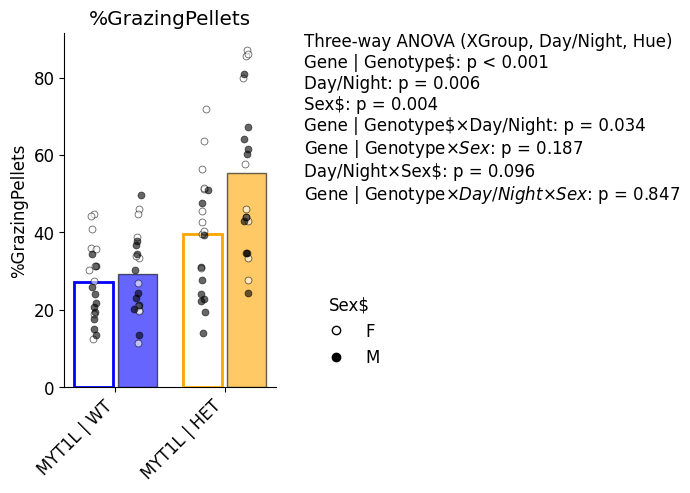

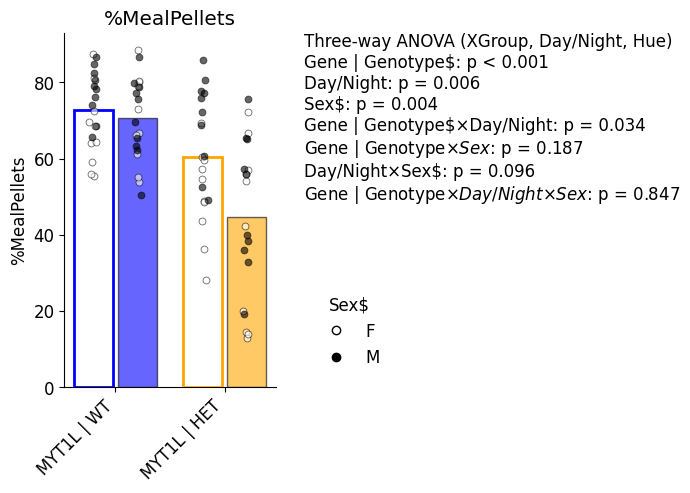

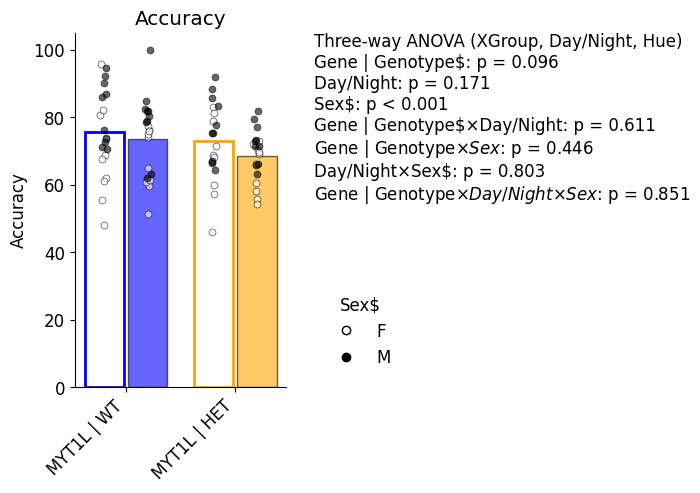

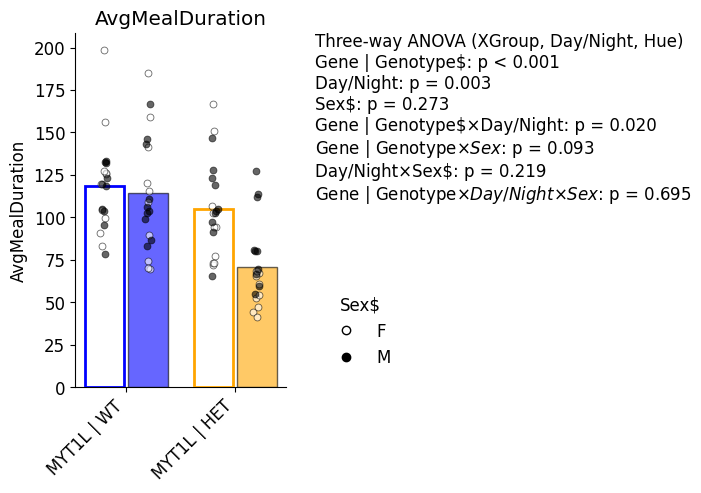

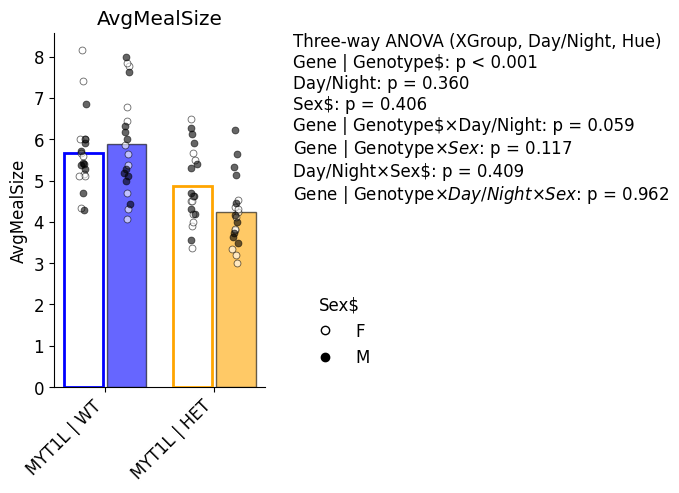

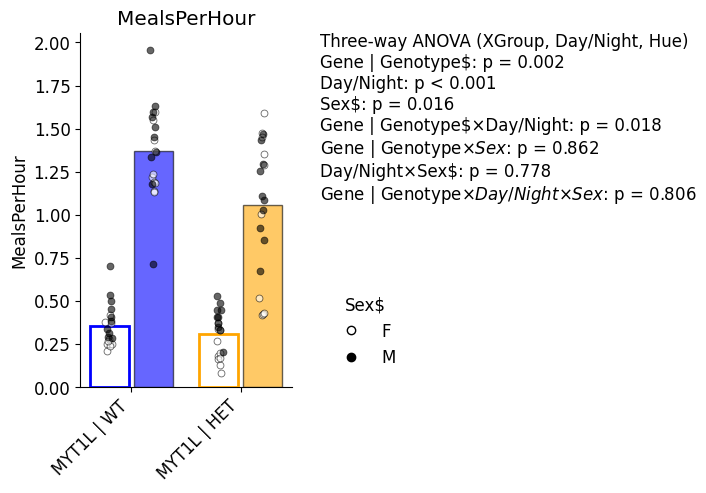

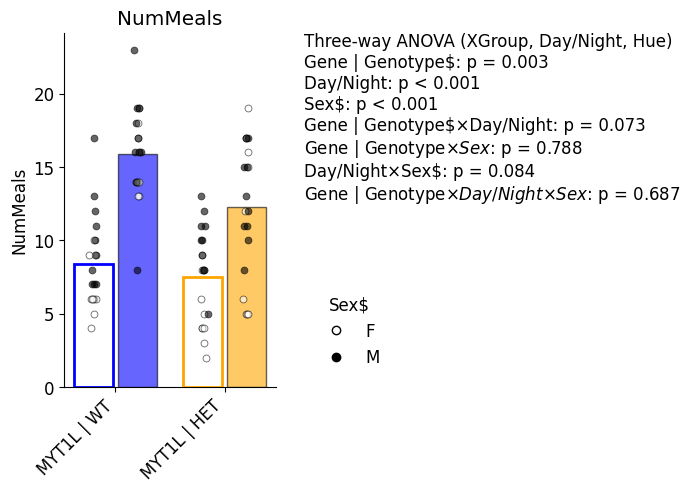

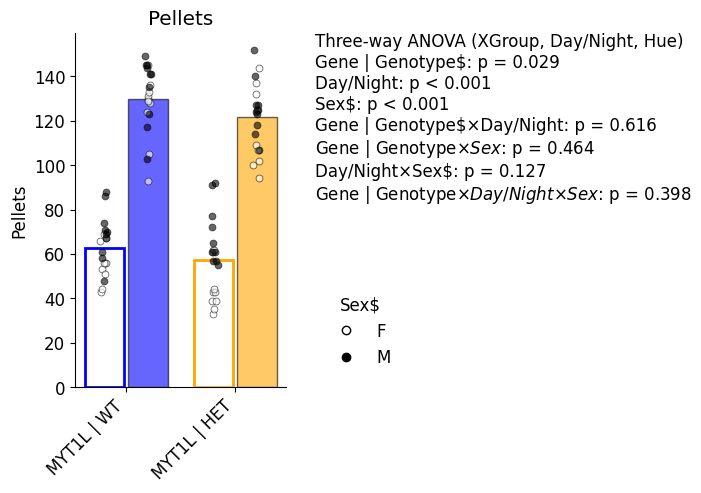

In [ ]:
#@title Day/Night metrics
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ---- Config ----
# If you want to force a specific set, set FORCE_BASES to a list of base names (without _Day/_Night)
FORCE_BASES = None  # e.g., ["%MealPellets","%GrazingPellets","Pellets","NumMeals","AvgMealSize","AvgMealDuration","MealsPerHour","Accuracy"]
DAY_TAG, NIGHT_TAG = "_Day", "_Night"
BAR_WIDTH = 0.36
NIGHT_ALPHA = 0.6
DOT_SIZE = 7
EDGE_LW_DAY = 2.0
EDGE_LW_NIGHT = 1.0

ALLOWED_DN_BASES = {
    "%MealPellets","%GrazingPellets","Pellets","NumMeals","AvgMealSize",
    "AvgMealDuration","MealsPerHour","Accuracy"
}

# ---- Helpers reused/compatible with previous cell ----
def _safe_order(groups):
    groups = [g for g in groups if pd.notna(g)]
    if '_order_x_groups' in globals():
        try:
            return _order_x_groups(groups)
        except Exception:
            pass
    return sorted(groups, key=lambda s: str(s).upper())

def _selected_x_groups():
    if 'x_checks' in globals() and isinstance(x_checks, dict) and len(x_checks):
        sel = [g for g, cb in x_checks.items() if getattr(cb, "value", False)]
        return _safe_order(sel)
    if 'long_df' not in globals():
        raise RuntimeError("long_df not found")
    return _safe_order(long_df["XGroup"].dropna().unique().tolist())

def _color_map(x_groups):
    if 'x_colors' in globals() and isinstance(x_colors, dict) and len(x_colors):
        out = {}
        for g in x_groups:
            w = x_colors.get(g, None)
            val = getattr(w, "value", None) if w is not None else None
            out[g] = (val.strip() if isinstance(val, str) and val.strip() else "blue")
        return out
    defaults = ["blue","orange","green","red","purple","brown","pink","gray","olive","cyan"]
    return {g: defaults[i % len(defaults)] for i, g in enumerate(x_groups)}

def _label_for(which="X"):
    if '_grouping_label' in globals():
        return _grouping_label(which)
    return "XGroup" if which.lower().startswith("x") else "HueGroup"

def _dot_palette_local(hues):
    if '_dot_palette' in globals():
        return _dot_palette(hues)
    hues = list(hues)
    if len(hues) == 0: return {}
    if len(hues) == 1: return {hues[0]: "black"}
    if len(hues) == 2: return {hues[0]: "white", hues[1]: "black"}
    defaults = plt.rcParams.get('axes.prop_cycle', None)
    colors = defaults.by_key()['color'] if defaults else ["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"]
    return {h: colors[i % len(colors)] for i, h in enumerate(hues)}

# ---- Day/Night extraction helpers ----
def _extract_dn_base(var_name):
    """
    From a long_df 'variable' like 'Pellets_Day' or 'Pellets_Day_FR1', return 'Pellets'.
    Returns None if it doesn't look like a Day/Night variable.
    """
    if "_Day" in var_name:
        return var_name.split("_Day", 1)[0]
    if "_Night" in var_name:
        return var_name.split("_Night", 1)[0]
    return None

def _ensure_daynight_view(df, base):
    """
    Build a tidy DataFrame with columns: XGroup, HueGroup, DayNight ('Day'/'Night'), value
    Works with variables that might include session suffixes (e.g., '<base>_Day_FR1').
    """
    patt_day = re.compile(rf"^{re.escape(base)}{re.escape(DAY_TAG)}(?:_.+)?$")
    patt_ngt = re.compile(rf"^{re.escape(base)}{re.escape(NIGHT_TAG)}(?:_.+)?$")
    keep_mask = df["variable"].astype(str).str.match(patt_day) | df["variable"].astype(str).str.match(patt_ngt)
    d = df.loc[keep_mask].copy()
    if d.empty:
        return d
    d["DayNight"] = np.where(d["variable"].str.match(patt_day), "Day", "Night")
    return d

def _discover_daynight_bases(df):
    vars_ = df["variable"].astype(str).unique().tolist()
    bases = sorted({b for v in vars_ for b in [_extract_dn_base(v)] if b})
    # Keep only bases we actually want to plot (and that make sense for FR1)
    bases = [b for b in bases if b in ALLOWED_DN_BASES]
    return bases

# ---- Stats text (ANOVA with Day/Night included) ----
def _anova_daynight_text(df_dn, x_label, hue_label):
    d = df_dn.dropna(subset=["value","XGroup","DayNight"]).copy()
    if d["XGroup"].nunique() < 2 or d["DayNight"].nunique() < 2:
        return "Too few groups or missing Day/Night to run ANOVA."

    has_hue = d["HueGroup"].nunique(dropna=True) >= 2
    try:
        if has_hue:
            model = ols('value ~ C(XGroup) + C(DayNight) + C(HueGroup) + '
                        'C(XGroup):C(DayNight) + C(XGroup):C(HueGroup) + '
                        'C(DayNight):C(HueGroup) + C(XGroup):C(DayNight):C(HueGroup)',
                        data=d).fit()
            an = sm.stats.anova_lm(model, typ=2)
            def pget(term):
                return float(an.loc[term, 'PR(>F)']) if term in an.index else np.nan
            def fmt(p):
                if not np.isfinite(p): return "n/a"
                return f"p = {p:.3f}" if p >= 0.001 else "p < 0.001"
            return (
                "Three-way ANOVA (XGroup, Day/Night, Hue)\n"
                f"{x_label}: {fmt(pget('C(XGroup)'))}\n"
                f"Day/Night: {fmt(pget('C(DayNight)'))}\n"
                f"{hue_label}: {fmt(pget('C(HueGroup)'))}\n"
                f"{x_label}×Day/Night: {fmt(pget('C(XGroup):C(DayNight)'))}\n"
                f"{x_label}×{hue_label}: {fmt(pget('C(XGroup):C(HueGroup)'))}\n"
                f"Day/Night×{hue_label}: {fmt(pget('C(DayNight):C(HueGroup)'))}\n"
                f"{x_label}×Day/Night×{hue_label}: {fmt(pget('C(XGroup):C(DayNight):C(HueGroup)'))}"
            )
        else:
            model = ols('value ~ C(XGroup) + C(DayNight) + C(XGroup):C(DayNight)', data=d).fit()
            an = sm.stats.anova_lm(model, typ=2)
            def fmt(p):
                if not np.isfinite(p): return "n/a"
                return f"p = {p:.3f}" if p >= 0.001 else "p < 0.001"
            return (
                "Two-way ANOVA (XGroup, Day/Night)\n"
                f"{_label_for('X')}: {fmt(float(an.loc['C(XGroup)','PR(>F)']))}\n"
                f"Day/Night: {fmt(float(an.loc['C(DayNight)','PR(>F)']))}\n"
                f"{_label_for('X')}×Day/Night: {fmt(float(an.loc['C(XGroup):C(DayNight)','PR(>F)']))}"
            )
    except Exception as e:
        return f"ANOVA failed: {e}"

# ---- Main plotting for a single base ----
def _plot_day_night_for_base(base, x_groups, color_map):
    df_dn = _ensure_daynight_view(long_df, base)
    df_dn = df_dn[df_dn["XGroup"].isin(x_groups)].copy()
    if df_dn.empty:
        print(f"Skipping {base}: no Day/Night data for selected groups.")
        return

    x_label = _label_for("X")
    hue_label = _label_for("Hue")

    hue_levels = [h for h in df_dn["HueGroup"].dropna().unique().tolist()]
    pal_dots = _dot_palette_local(hue_levels)

    means = (df_dn.dropna(subset=["value"])
                  .groupby(["XGroup","DayNight"], as_index=False)["value"]
                  .mean().rename(columns={"value":"mean"}))
    grid = (means.set_index(["XGroup","DayNight"])["mean"]
                 .unstack("DayNight")
                 .reindex(index=x_groups, columns=["Day","Night"]))

    width = max(4, 1.2 * len(x_groups))
    fig, (ax, ax_txt) = plt.subplots(1, 2, figsize=(width, 4.6), gridspec_kw={'width_ratios': [3, 1]})

    x = np.arange(len(x_groups))
    off = BAR_WIDTH/2.0 + 0.02
    pos_day = x - off
    pos_night = x + off

    # Night bars (filled)
    for i, g in enumerate(x_groups):
        val = grid.loc[g, "Night"] if ("Night" in grid.columns) else np.nan
        if pd.notna(val):
            ax.bar(pos_night[i], val, width=BAR_WIDTH, color=color_map[g],
                   alpha=NIGHT_ALPHA, edgecolor="black", linewidth=EDGE_LW_NIGHT, zorder=2)

    # Day bars (outline)
    for i, g in enumerate(x_groups):
        val = grid.loc[g, "Day"] if ("Day" in grid.columns) else np.nan
        if pd.notna(val):
            ax.bar(pos_day[i], val, width=BAR_WIDTH, facecolor=(0,0,0,0),
                   edgecolor=color_map[g], linewidth=EDGE_LW_DAY, zorder=3)

    # Overlay individual dots by HueGroup
    rng = np.random.default_rng(42)
    jitter = lambda n: (rng.normal(0, 0.02, size=n))

    # Day dots (outline markers)
    sdf = df_dn[df_dn["DayNight"] == "Day"].dropna(subset=["value"])
    for g in x_groups:
        sub = sdf[sdf["XGroup"] == g]
        if sub.empty: continue
        px = pos_day[x_groups.index(g)]
        for h in sub["HueGroup"].unique():
            hh = sub[sub["HueGroup"] == h]
            if hh.empty: continue
            ax.scatter(np.full(len(hh), px) + jitter(len(hh)), hh["value"],
                       s=DOT_SIZE**2/2, facecolors=pal_dots.get(h, "black"),
                       edgecolors="black", linewidths=0.6, alpha=NIGHT_ALPHA, zorder=4)

    # Night dots (filled markers)
    sdf = df_dn[df_dn["DayNight"] == "Night"].dropna(subset=["value"])
    for g in x_groups:
        sub = sdf[sdf["XGroup"] == g]
        if sub.empty: continue
        px = pos_night[x_groups.index(g)]
        for h in sub["HueGroup"] == sub["HueGroup"]:
            pass  # to keep structure clear
        for h in sub["HueGroup"].unique():
            hh = sub[sub["HueGroup"] == h]
            if hh.empty: continue
            ax.scatter(np.full(len(hh), px) + jitter(len(hh)), hh["value"],
                       s=DOT_SIZE**2/2, facecolors=pal_dots.get(h, "black"),
                       edgecolors="black", linewidths=0.6, alpha=NIGHT_ALPHA, zorder=4)

    ax.set_xticks(x)
    ax.set_xticklabels(x_groups, rotation=45, ha="right")
    ax.set_ylabel(base)
    ax.set_title(f"{base}")
    sns.despine(ax=ax)

    ax_txt.axis("off")
    ax_txt.text(0, 1, _anova_daynight_text(df_dn, x_label, hue_label),
                va="top", ha="left", fontsize=12, transform=ax_txt.transAxes)

    if len(hue_levels) >= 2:
        handles = [plt.Line2D([0],[0], marker='o', linestyle='None',
                              markerfacecolor=pal_dots[h], markeredgecolor='black',
                              label=str(h)) for h in hue_levels]
        ax_txt.legend(handles=handles, title=hue_label,
                      loc="upper left", bbox_to_anchor=(0, 0.3),
                      frameon=False)
    plt.tight_layout()
    plt.show()

# ---- Run ----
if 'long_df' not in globals():
    raise RuntimeError("This cell expects long_df from the previous cell.")

Xsel = _selected_x_groups()
if not Xsel:
    print("No X groups selected or available.")
else:
    cmap = _color_map(Xsel)
    if FORCE_BASES is not None:
        BASES = [b for b in FORCE_BASES if b in ALLOWED_DN_BASES]
    else:
        BASES = _discover_daynight_bases(long_df)
    if not BASES:
        print("No Day/Night metrics found in long_df.")
    else:
        for base in BASES:
            _plot_day_night_for_base(base, Xsel, cmap)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 900x500 with 0 Axes>

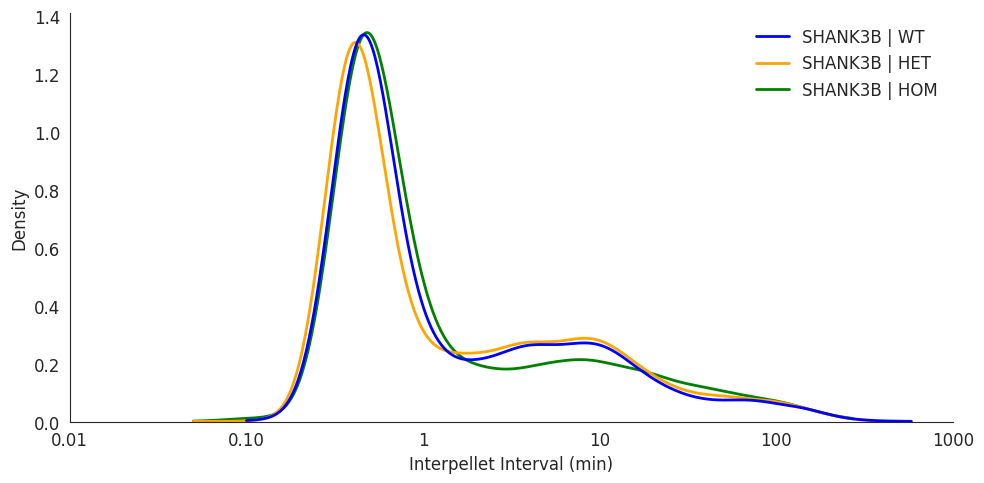

In [ ]:
# @title Interpellet intervals

import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Collect IPI from file_to_df
if "file_to_df" not in globals():
    if "loaded_files" in globals() and "feds" in globals():
        file_to_df = {Path(str(fname)).name: df for fname, df in zip(loaded_files, feds)}
    else:
        raise RuntimeError("Missing `file_to_df`.")

rows = []
for fname, df in file_to_df.items():
    if df is None or df.empty:
        continue
    if "Event" in df.columns:
        df = df[df["Event"].isin(["Left","Right","Pellet"])].copy()
    if "InterPelletInterval" not in df.columns:
        continue
    vals = pd.to_numeric(df["InterPelletInterval"], errors="coerce").dropna()
    vals = vals[vals > 0]
    if vals.empty:
        continue
    base = os.path.basename(str(fname))
    rows.extend({"filename": base, "IPI_s": float(v)} for v in vals)

ipi = pd.DataFrame(rows)
if ipi.empty:
    raise RuntimeError("No InterPelletInterval values found.")

# 2) Merge XGroup from files_to_group_both (ignore Hue)
if "files_to_group_both" not in globals() or files_to_group_both is None or files_to_group_both.empty:
    raise RuntimeError("Missing `files_to_group_both`. Build Groups first.")

grp = files_to_group_both.copy()
src_col = "filename" if "filename" in grp.columns else ("File" if "File" in grp.columns else None)
if src_col is None:
    raise RuntimeError("`files_to_group_both` needs 'filename' or 'File'.")
grp["filename"] = grp[src_col].astype(str).map(os.path.basename)
ipi = ipi.merge(grp[["filename","XGroup"]].drop_duplicates(), on="filename", how="left")
ipi["XGroup"] = ipi["XGroup"].fillna("UNASSIGNED")

# 3) Choose groups: all checked in widget, else all present
def _selected_xgroups():
    if 'x_checks' in globals() and isinstance(x_checks, dict) and len(x_checks):
        return [g for g, cb in x_checks.items() if getattr(cb, "value", False)]
    return sorted(ipi["XGroup"].dropna().unique().tolist())

chosen = _selected_xgroups()
if not chosen:
    raise RuntimeError("No XGroups selected/found.")
ipi2 = ipi[ipi["XGroup"].isin(chosen)].copy()

# 4) KDE in log10 space (correct for log-x plotting)
ipi2 = ipi2[(ipi2["IPI_s"] > 0) & np.isfinite(ipi2["IPI_s"])]
ipi2["log10_IPI"] = np.log10(ipi2["IPI_s"])

# --- Match order & colors from the main plotting cell ---

_present = ipi2["XGroup"].dropna().unique().tolist()

# ORDER: prefer the global ordered_x (WT/CONTROL-first); otherwise reproduce rule locally
if "ordered_x" in globals():
    group_order = [g for g in ordered_x if g in _present] + [g for g in _present if g not in ordered_x]
else:
    import re
    def _is_wt(g):
        toks = [t for t in re.split(r'[^A-Z0-9]+', str(g).upper()) if t]
        return any(t in {"WT", "WILDTYPE", "CONTROL", "CTRL"} for t in toks)
    def _x_levels(g): return [p.strip() for p in str(g).split("|")]
    def _key(g):
        lv = _x_levels(g)
        wt_rank = 0 if any(_is_wt(tok) for tok in lv) or _is_wt(g) else 1
        blanks = [(1 if s.strip().upper() in {"","UNASSIGNED","NONE","NA","N/A"} else 0, s.upper()) for s in lv]
        return (wt_rank, *blanks, str(g).upper())
    group_order = sorted(_present, key=_key)

# COLORS: pull from x_colors (widgets) so bars/lines/KDE match
palette_map = None
if "x_colors" in globals() and isinstance(x_colors, dict) and x_colors:
    def _col(g):
        try:
            v = x_colors[g].value
            return v.strip() if isinstance(v, str) and v.strip() else "tab:blue"
        except Exception:
            return "tab:blue"
    palette_map = {g: _col(g) for g in group_order}

# ---- PLOT ONLY (no metric computation) ----
sns.set_style("white")
plt.figure(figsize=(9, 5))
sns.set_style("white")
fig, ax = plt.subplots(figsize=(10, 5))

# convert seconds to minutes and compute log10 in minutes
ipi2["IPI_min"] = ipi2["IPI_s"] / 60.0
ipi2 = ipi2[(ipi2["IPI_min"] > 0) & np.isfinite(ipi2["IPI_min"])]
ipi2["log10_IPI_min"] = np.log10(ipi2["IPI_min"])

# plot KDE in log10(minutes)
ax = sns.kdeplot(
    data=ipi2,
    x="log10_IPI_min",
    hue="XGroup",
    hue_order=group_order,
    palette=palette_map,
    fill=False,
    common_norm=False,
    cut=0,
    bw_adjust=0.9,
    gridsize=512,
    linewidth=2
)

# Nice decade ticks based on data range (in log10 minutes)
lo = np.floor(ipi2["log10_IPI_min"].min())
hi = np.ceil(ipi2["log10_IPI_min"].max())
ticks_log = np.arange(lo, hi + 1)
ax.set_xticks(ticks_log)

def _min_label(t):
    v = 10.0 ** float(t)  # minutes
    # format: show 2 decimals if <1 min, otherwise integer minutes
    return f"{v:.2f}" if v < 1 else f"{int(round(v))}"

ax.set_xticklabels([_min_label(t) for t in ticks_log])
ax.set_xlabel("Interpellet Interval (min)")
ax.set_ylabel("Density")
ax.set_title("")
leg = ax.get_legend()
if leg:
    leg.set_title("")
    leg.set_frame_on(False)
sns.despine()
plt.tight_layout()

# Embed TrueType fonts so text stays editable in Illustrator/Inkscape
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

outdir = "figures"
os.makedirs(outdir, exist_ok=True)
from datetime import datetime
fname = f"interpellet_histogram_{datetime.now():%Y-%m-%d}.pdf"
fig = ax.get_figure()
fig.savefig(
    os.path.join(outdir, fname),
    format="pdf",
    bbox_inches="tight",
    transparent=True,
)
files.download(os.path.join(outdir, fname))
plt.show()

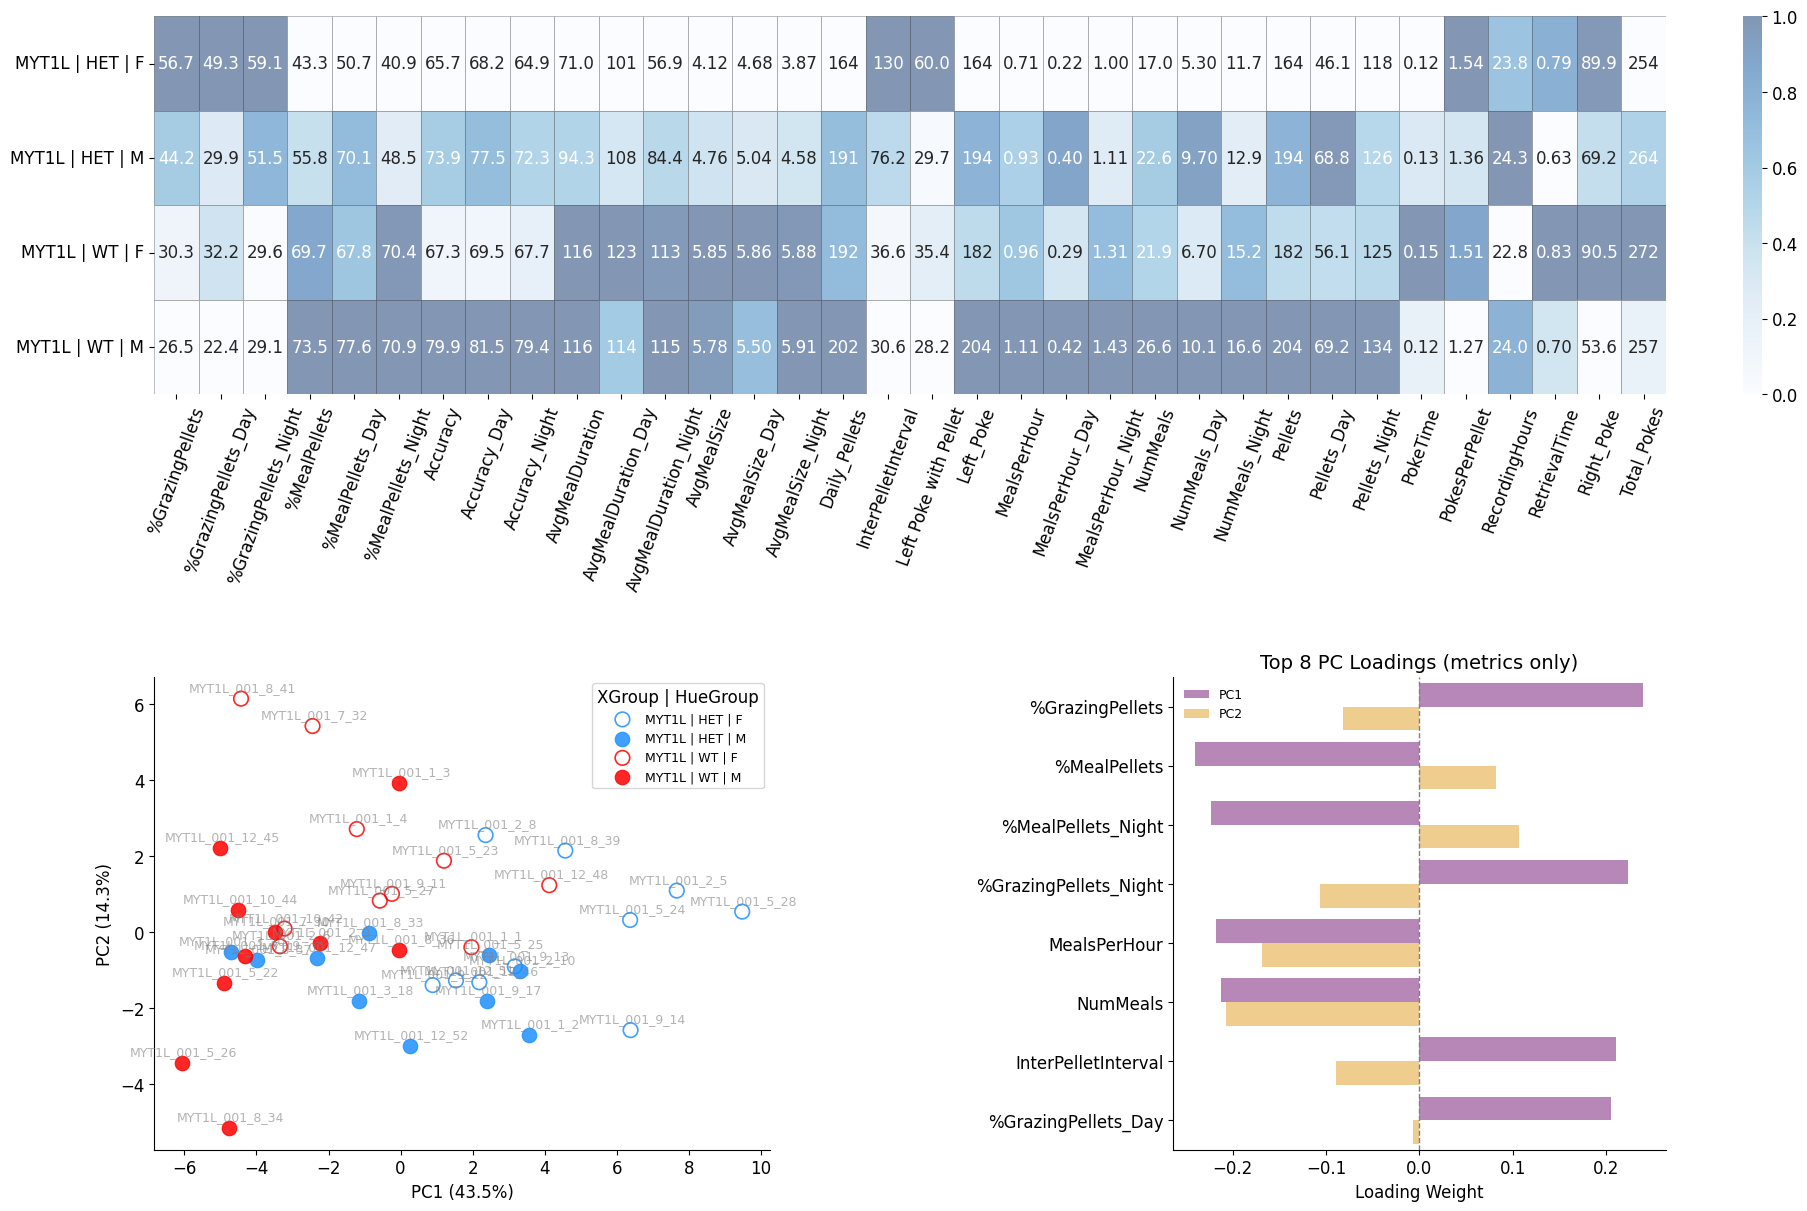

In [ ]:
# @title Cluster FR1 by heatmap & PCA (X/Hue from Group UI; generic labels/markers)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ---------- Pick FR1 source ----------
if 'FR1metrics_merged' in globals() and FR1metrics_merged is not None and not FR1metrics_merged.empty:
    FR1_src = FR1metrics_merged.copy()
elif 'FR1metrics_csv' in globals() and FR1metrics_csv is not None and not FR1metrics_csv.empty:
    FR1_src = FR1metrics_csv.copy()
elif 'FR1metrics' in globals() and FR1metrics is not None and not FR1metrics.empty:
    FR1_src = FR1metrics.copy()
else:
    raise RuntimeError("No FR1 table found. Expect FR1metrics_merged, FR1metrics_csv, FR1metrics, or FR1_metrics.")

# Ensure we have a File column (fallback from filename if needed)
if 'File' not in FR1_src.columns:
    if 'filename' in FR1_src.columns:
        FR1_src = FR1_src.copy()
        FR1_src['File'] = FR1_src['filename'].astype(str)
    else:
        raise RuntimeError("FR1 table must include 'File' or 'filename' column.")

# ---------- Groups from the Group UI ----------
def _basename(p): return os.path.basename(str(p))

if 'files_to_group_both' in globals() and files_to_group_both is not None and not files_to_group_both.empty:
    grp_map = files_to_group_both.copy()
    src_col = 'filename' if 'filename' in grp_map.columns else 'File'
    grp_map["File_base"] = grp_map[src_col].astype(str).apply(_basename)
    grp_map = grp_map[["File_base","XGroup","HueGroup"]]
else:
    raise RuntimeError("No groups found. Run the 'Group for plotting' widget (two-column) and click 'Build Groups'.")
# Ensure both tables have a File_base column built from the filename/File
FR1_src = FR1_src.copy()
src_col_fr1 = 'filename' if 'filename' in FR1_src.columns else 'File'
FR1_src['File_base'] = FR1_src[src_col_fr1].astype(str).apply(_basename)

# grp_map already has File_base from earlier code
# Merge groups onto FR1; each file should map to at most one (XGroup, HueGroup)
ldf = (
    FR1_src.merge(
        grp_map, on='File_base', how='left', validate='m:1'
    )
)

# Helpful checks
if {'XGroup','HueGroup'}.issubset(ldf.columns) and ldf[['XGroup','HueGroup']].isna().all().all():
    raise RuntimeError(
        "Group merge completed but all XGroup/HueGroup are NaN. "
        "Check that the basename in FR1 matches the Group UI table."
    )
# ---------- STRICT METRIC SELECTION (whitelist patterns) ----------
# Base metric names (covers base, _Day/_Night, and any extra suffix like _FR1)
_METRIC_BASES = [
    "Pellets","Left_Poke","Right_Poke","Total_Pokes","Accuracy","PokesPerPellet",
    "RetrievalTime","InterPelletInterval","PokeTime",
    "%MealPellets","%GrazingPellets","NumMeals","AvgMealSize","AvgMealDuration",
    "RecordingHours","MealsPerHour","Daily_Pellets","Left Poke with Pellet",
]

def _metric_regex_from_bases(bases):
    safes = [re.escape(b) for b in bases]
    # Match base; optionally _Day/_Night; optionally any further suffix (e.g., _FR1)
    return re.compile(rf"^(?:{'|'.join(safes)})(?:_(?:Day|Night))?(?:_.+)?$")

_METRIC_RX = _metric_regex_from_bases(_METRIC_BASES)

# Identify metric columns by name pattern only (ignore dtype), exclude ids explicitly
ID_LIKE = {
    "File","filename","Mouse_ID","Strain","Sex","Genotype","Session_type",
    "File_base","XGroup","HueGroup"
}
metric_columns = [c for c in ldf.columns if isinstance(c, str) and _METRIC_RX.match(c) and c not in ID_LIKE]
if not metric_columns:
    raise RuntimeError("No metric columns matched the whitelist patterns. Check column names or base lists.")

# Coerce metric columns to numeric safely
for c in metric_columns:
    ldf[c] = pd.to_numeric(ldf[c], errors="coerce")

# ---------- Build long & wide ----------
id_keep = [c for c in ["File","filename","Mouse_ID","Strain","Sex","Genotype","Session_type","XGroup","HueGroup"] if c in ldf.columns]

long_df = ldf.melt(
    id_vars=id_keep,
    value_vars=metric_columns,
    var_name="metric",
    value_name="value"
).copy()

# Wide (one row per file/animal), average duplicates
wide_index = [c for c in ["File","filename","Mouse_ID","Strain","Sex","Genotype","XGroup","HueGroup"] if c in long_df.columns]
wide_metrics = (
    long_df.pivot_table(
        index=wide_index,
        columns="metric",
        values="value",
        aggfunc="mean",
        observed=True
    )
    .reset_index()
)

# The metric columns are exactly those we whitelisted
metric_columns = [c for c in wide_metrics.columns if c not in wide_index]

# ---------- Group means by XGroup (for heatmap & PCA feature set) ----------
if ("XGroup" not in wide_metrics.columns) or ("HueGroup" not in wide_metrics.columns):
    raise RuntimeError("XGroup and HueGroup are required to cluster on both.")

# Order rows as a stable product of XGroup then HueGroup
_x_order = sorted(wide_metrics["XGroup"].astype(str).unique())
_h_order = sorted(wide_metrics["HueGroup"].astype(str).unique())

group_means = (
    wide_metrics
    .assign(XGroup=wide_metrics["XGroup"].astype(str),
            HueGroup=wide_metrics["HueGroup"].astype(str))
    .groupby(["XGroup", "HueGroup"], dropna=False)[metric_columns]
    .mean()
    .reindex(pd.MultiIndex.from_product([_x_order, _h_order],
                                        names=["XGroup","HueGroup"]))
)

# Build a readable index like "X | Hue" for the heatmap rows
group_means.index = [f"{x} | {h}" for x, h in group_means.index]

# ---------- Heatmap (min–max per column, with numeric annotations) ----------
def _fmt_cell(x):
    if pd.isna(x): return ""
    ax = abs(float(x))
    return f"{x:.0f}" if ax >= 100 else f"{x:.1f}" if ax >= 10 else f"{x:.2f}"

annot_data = group_means.applymap(_fmt_cell)

heatmap_scaled = group_means.copy()
for col in heatmap_scaled.columns:
    col_min, col_max = heatmap_scaled[col].min(), heatmap_scaled[col].max()
    if pd.isna(col_min) or pd.isna(col_max):
        heatmap_scaled[col] = 0.0
    elif col_max == col_min:
        heatmap_scaled[col] = 0.5  # constant column → mid tone
    else:
        heatmap_scaled[col] = (heatmap_scaled[col] - col_min) / (col_max - col_min)

heatmap_scaled = heatmap_scaled.sort_index()
annot_data = annot_data.loc[heatmap_scaled.index]

# ---------- PCA (same metric set) ----------
pca_features = metric_columns[:]  # same set used in heatmap
mouse_data = wide_metrics.dropna(subset=pca_features).copy()

# Labels: prefer Mouse_ID, else filename (basename), else File
if "Mouse_ID" in mouse_data.columns and mouse_data["Mouse_ID"].notna().any():
    labels = mouse_data["Mouse_ID"].astype(str)
elif "filename" in mouse_data.columns and mouse_data["filename"].notna().any():
    labels = mouse_data["filename"].astype(str).apply(lambda p: os.path.basename(str(p)))
else:
    labels = mouse_data["File"].astype(str)
mouse_data["Label"] = labels

# Ensure grouping columns exist as strings
for col, default in [("XGroup", "UNASSIGNED"), ("HueGroup", "ALL")]:
    if col in mouse_data.columns:
        mouse_data[col] = mouse_data[col].astype(str)
    else:
        mouse_data[col] = default

# Standardize metrics and run PCA
X = StandardScaler().fit_transform(mouse_data[pca_features].values)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["Label"]    = mouse_data["Label"].values
pca_df["XGroup"]   = mouse_data["XGroup"].values
pca_df["HueGroup"] = mouse_data["HueGroup"].values

# Loadings (top 8 by |PC1|)
loadings = pd.DataFrame(pca.components_.T, index=pca_features, columns=["PC1", "PC2"])
top8_features = loadings.reindex(loadings["PC1"].abs().sort_values(ascending=False).head(8).index)
loadings_melted = top8_features[["PC1", "PC2"]].reset_index().melt(id_vars="index", var_name="PC", value_name="Loading")

# ---------- Plot (1×3 grid) ----------
fig = plt.figure(figsize=(18, 12), constrained_layout=True)
gs = gridspec.GridSpec(
    2, 2, figure=fig,
    height_ratios=[0.8, 1.0],
    width_ratios=[1.0, 0.8],
    hspace=0.1, wspace=0.1
)

# Top: heatmap spans both columns
ax_heat    = fig.add_subplot(gs[0, :])
# Bottom: scatter (left) and bar (right)
ax_scatter = fig.add_subplot(gs[1, 0])
ax_bar     = fig.add_subplot(gs[1, 1])

# 1) Heatmap of XGroup means
sns.heatmap(
    heatmap_scaled,
    ax=ax_heat,
    annot=annot_data.values,
    fmt="",
    cmap="Blues",
    linewidths=0.5,
    linecolor='gray',
    alpha=0.5,
    cbar=True
)
ax_heat.tick_params(axis='x', rotation=70)
ax_heat.tick_params(axis='y', rotation=0)
ax_heat.set_title("", fontsize=16, color="darkblue")
ax_heat.set_xlabel(""); ax_heat.set_ylabel("")

# 2) PCA: color by XGroup; marker encodes HueGroup
unique_x = sorted(pca_df["XGroup"].unique())

# color map for XGroup
x_colors = {}
if len(unique_x) >= 1: x_colors[unique_x[0]] = "dodgerblue"
if len(unique_x) >= 2: x_colors[unique_x[1]] = "red"
if len(unique_x) > 2:
    cmap = cm.get_cmap("tab20", len(unique_x) - 2)
    for i, grp in enumerate(unique_x[2:]):
        x_colors[grp] = mcolors.to_hex(cmap(i))

# marker selection for HueGroup
all_hues = sorted([h for h in pca_df["HueGroup"].unique()])
if len(all_hues) == 0:
    all_hues = ["ALL"]
if len(all_hues) == 1:
    hue_to_marker = {all_hues[0]: ("o", "filled")}
elif len(all_hues) == 2:
    hue_to_marker = {all_hues[0]: ("o", "hollow"), all_hues[1]: ("o", "filled")}
else:
    marker_cycle = ["o", "s", "^", "D", "P", "X", "*", "v", "<", ">"]
    hue_to_marker = {h: (marker_cycle[i % len(marker_cycle)], "filled") for i, h in enumerate(all_hues)}

# draw points: loop XGroup (color), then HueGroup (marker style)
for xg in unique_x:
    sub_x = pca_df[pca_df["XGroup"] == xg]
    for hg in all_hues:
        sub = sub_x[sub_x["HueGroup"] == hg]
        if sub.empty:
            continue
        marker, fill = hue_to_marker[hg]
        if fill == "hollow":
            ax_scatter.scatter(
                sub["PC1"], sub["PC2"],
                edgecolors=x_colors.get(xg, "black"), facecolors="none",
                s=110, linewidth=1.2, marker=marker, alpha=0.85,
                label=f"{xg} | {hg}"
            )
        else:  # filled
            ax_scatter.scatter(
                sub["PC1"], sub["PC2"],
                color=x_colors.get(xg, "black"),
                s=110, linewidth=0.8, marker=marker, alpha=0.85,
                label=f"{xg} | {hg}"
            )

# point labels
for _, row in pca_df.iterrows():
    ax_scatter.text(
        row["PC1"] + 0.05, row["PC2"] + 0.12, str(row["Label"]),
        fontsize=9, color="gray", alpha=0.6, ha="center", va="bottom"
    )

ax_scatter.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax_scatter.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")

# legend (dedup + sorted)
handles, labels = ax_scatter.get_legend_handles_labels()
pairs = sorted({(lab, h) for lab, h in zip(labels, handles)}, key=lambda x: x[0])
if pairs:
    sorted_labels, sorted_handles = zip(*pairs)
    ax_scatter.legend(sorted_handles, sorted_labels, frameon=True, title="XGroup | HueGroup", fontsize=9)

# 3) Loadings barplot
sns.barplot(
    data=loadings_melted, y="index", x="Loading",
    hue="PC", hue_order=["PC1", "PC2"],
    ax=ax_bar, palette=["purple", "orange"], alpha=0.5
)
ax_bar.set_xlabel("Loading Weight")
ax_bar.set_title("Top 8 PC Loadings (metrics only)", fontsize=14)
ax_bar.axvline(0, color='gray', linestyle='--', linewidth=1)
ax_bar.set_ylabel("")
ax_bar.legend(title="", frameon=False, fontsize=9)

plt.show()